# EECS 498-007/598-005 Assignment 5-2: Transformers

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**\
Hello WORLD, #XXXXXXXX

### Transformers ([Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf))

To this point we have seen RNNs, which excel at sequence to sequence task but have two major drawbacks.
First, they can suffer from vanishing gradients for long sequences.
Second, they can take a long time to train due to sequential dependencies between hidden states which does not take advantage of the massively parallel architecture of modern GPUs.
The first issue is largely addressed by alternate RNN architectures (LSTMs, GRUs) but not the second.

Transformers solve these problems up to a certain extent by enabling to process the input parallely during training with long sequences. Though the computation is quadratic with respect to the input sequence length, it still managable with modern GPUs.

In this notebook, we will implement Transformers model step-by-step by referencing the original paper, [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf). We will also use a toy dataset to solve a vector-to-vector problem which is a subset of sequence-to-sequence problem.

## Table of Contents

This assignment has 4 parts. In the class we learned about Encoder based Transformers but often we use an Encoder and a Decoder for sequence to sequence task. In this notebook, you will learn how to implement an Encoder-Decoder based Transformers in a step-by-step manner. We will implement a simpler version here, where the simplicity arise from the task that we are solving, which is a vector-to-vector task. This essentially means that the length of input and output sequence is **fixed** and we dont have to worry about variable length of sequences. This makes the implementation simpler.

1. **Part I (Preparation)**: We will preprocess a toy dataset that consists of input arithmetic expression and an output result of the expression
1. **Part II (Implement Transformer blocks)**: we will look how to implement building blocks of a Transformer. It will consist of following blocks
   1. MultiHeadAttention
   2. FeedForward
   3. LayerNorm
   4. Encoder Block
   5. Decoder Block
1. **Part III (Data Loading)**: We will use the preprocessing functions in part I and the positional encoding module to construct the Dataloader.
1. **Part IV (Train a model)**: In the last part we will look at how to fit the implemented Transformer model to the toy dataset.

You can run all things on CPU till part 3. Part 4 requires GPU and while changing the runtime for this part, you would also have to run all the previous parts as part 4 has dependency on previous parts.

# Part I. Preparation

Before getting started we need to run some boilerplate code to set up our environment. You"ll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
["eecs598", "a5_helper.py", "rnn_lstm_attention_captioning.ipynb",  "rnn_lstm_attention_captioning.py", "Transformers.py", "Transformers.ipynb"]
```

In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a WI2022 folder and put all the files under A5 folder, then "WI2022/A5"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None

GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive",'DL4CV','A5')
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.

sys.path.append(GOOGLE_DRIVE_PATH)

['a5_helper.py', 'two_digit_op.json', 'eecs598', '__pycache__', 'rnn_lstm_captioning.ipynb', 'rnn_lstm_captioning.py', 'transformers.py', 'Transformers.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from Transformers.py!
```

as well as the last edit time for the file `Transformers.py`.

In [4]:
import os
import time
from transformers import hello_transformers

hello_transformers()


os.environ["TZ"] = "US/Eastern"
time.tzset()
hello_transformers()

transformers_path = os.path.join(GOOGLE_DRIVE_PATH, "transformers.py")
transformers_edit_time = time.ctime(os.path.getmtime(transformers_path))
print("transformers.py last edited on %s" % transformers_edit_time)

ImportError: cannot import name 'hello_transformers' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

In [5]:
import torch
import torch.nn.functional as F
from torch import Tensor
from torch import nn

import torch

from torch import nn
import torch.nn.functional as F

from eecs598.utils import (
    reset_seed,
    tensor_to_image,
    attention_visualizer,
)
from eecs598.grad import rel_error, compute_numeric_gradient
import matplotlib.pyplot as plt
import time
from IPython.display import Image


# for plotting
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

We will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

We will be using `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [6]:
to_float = torch.float
to_long = torch.long

if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


### Load the toy data

As Transformers perform very well on sequence to sequence task, we will implement it on a toy task of Arithmetic operations. We will use transformer models to perform addition and subraction of two integers, where the absolute value of an integer is at most 50. A simple example is to perform the computation `-5 + 2` using a Transformer model and getting the corect result as `-3`. As there can be multiple ways to solve this problem, we will see how we can pose this as a sequence to sequence problem and solve it using Transformers model. Note that we had to reduce the complexity of the problem to make the Transformer work within the constrainted resources of Colab.

Lets take a look at the data first:

In [7]:
from a5_helper import get_toy_data

# load the data using helper function
data = get_toy_data(os.path.join(GOOGLE_DRIVE_PATH,"two_digit_op.json"))

### Looking at the first four examples

Below are the first four samples in the data

In [ ]:
num_examples = 4
for q, a in zip(
    data["inp_expression"][:num_examples],
    data["out_expression"][:num_examples]
    ):
  print("Expression: " + q + " Output: " + a)

Expression: BOS NEGATIVE 30 subtract NEGATIVE 34 EOS Output: BOS POSITIVE 04 EOS
Expression: BOS NEGATIVE 34 add NEGATIVE 15 EOS Output: BOS NEGATIVE 49 EOS
Expression: BOS NEGATIVE 28 add NEGATIVE 36 EOS Output: BOS NEGATIVE 64 EOS
Expression: BOS POSITIVE 00 subtract POSITIVE 17 EOS Output: BOS NEGATIVE 17 EOS


## What do these examples mean:

Lets look at first and third examples here and understand what they represent:

- Expression: `BOS NEGATIVE 30 subtract NEGATIVE 34 EOS` Output: `BOS POSITIVE 04 EOS`: The expression here is $(-30) - (-34)$. There are two notions of the symbol `+` here: one is to denote the sign of the number and other is the operation of addition between two integers. To simplify the problem for the neural network, we have denoted them with different text tokens. The ouput of $(-30) - (-34)$ is $+4$. Here `BOS` and `EOS` refer to begining of sequence and end of sequence
- Similarly, the second expression, `BOS NEGATIVE 34 add NEGATIVE 15 EOS` Output: `BOS NEGATIVE 49 EOS` means that we are doing the computation as $(-34) + (-15)$. As above, the symbol `-` here represents two things: first is the sign of an integer and second is the operation between two integers. Again, we have represented with different tokens to simplify the problem for the neural network. The output here is -49. Here `BOS` and `EOS` refer to begining of sequence and end of sequence

Now that we have a grasp on what is the data, lets head to preprocess the data, as the neural networks don't really understand strings, we need to represent them as numbers.

## Pre-processing the data
We need to convert the raw input sequence into a format that can be processed with a neural network.
Concretely, we need to convert a human-readable string (e.g. `BOS NEGATIVE 30 subtract NEGATIVE 34 EOS`) into a sequence of **tokens**, each of which will be an integer.
The process of converting an input string into a sequence of tokens is known as **tokenization**.

Before we can tokenize any particular sequence, we first need to build a **vocabulary**;
this is an exhaustive list of all tokens that appear in our dataset, and a mapping from each token to a unique integer value.
In our case, our vocabulary with consist of 16 elements: one entry for each digit `0` to `9`, two tokens to represent the sign of a number (`POSITIVE` and `NEGATIVE`), two tokens representing the addition and subtraction operations (`add`, and `subtract`), and finally two special tokens representing the start and end of the sequence (`BOS`, `EOS`).

We typically represent the vocabulary with a pair of data structures.
First is a list of all the string tokens (`vocab` below), such that `vocab[i] = s` means that the string `s` has been assigned the integer value `i`. This allows us to look up the string associated with any numeric index `i`.
We also need a data structure that enables us to map in the other direction: given a string `s`, find the index `i` to which it has been assigned. This is typically represented as a hash map (`dict` object in Python) whose keys are strings and whose values are the indices assigned to those strings.
You will implement the function `generate_token_dict` that inputs the list `vocab` and returns a dict `convert_str_to_token` giving this mapping.

Once you have built the vocab, then you can implement the function `preprocess_input_sequence` which uses the vocab data structures to convert an input string into a list of integer tokens.

In [11]:
# Create vocab
SPECIAL_TOKENS = ["POSITIVE", "NEGATIVE", "add", "subtract", "BOS", "EOS"]
vocab = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] + SPECIAL_TOKENS

To generate the hash map and then process the input string using them, complete the `generate_token_dict`, `prepocess_input_sequence` functions in the python files for this exercise:

You should see exact zero errors here

In [12]:
def generate_token_dict(vocab):
    """
    The function creates a hash map from the elements in the vocabulary to
    to a unique positive integer value.

    args:
        vocab: This is a 1D list of strings containing all the items in the vocab

    Returns:
        token_dict: a python dictionary with key as the string item in the vocab
            and value as a unique integer value
    """
    # initialize a empty dictionary
    token_dict = {}
    ##############################################################################
    # TODO: Use this function to assign a unique whole number element to each    #
    # element present in the vocab list. To do this, map the first element in the#
    # vocab to 0 and the last element in the vocab to len(vocab), and the        #
    # elements in between as consequetive number.                                #
    ##############################################################################
    # Replace "pass" statement with your code
    for index, token in enumerate(vocab):
        token_dict[token] = index
    ##############################################################################
    #               END OF YOUR CODE                                             #
    ##############################################################################
    return token_dict

convert_str_to_tokens = generate_token_dict(vocab)

try:
    assert convert_str_to_tokens["0"] == 0
except:
    print("The first element does not map to 0. Please check the implementation")

try:
    assert convert_str_to_tokens["EOS"] == 15
except:
    print("The last element does not map to 2004. Please check the implementation")

print("Dictionary created successfully!")

Dictionary created successfully!


In [13]:
def generate_token_dict(vocab):
    """
    The function creates a hash map from the elements in the vocabulary to
    to a unique positive integer value.

    args:
        vocab: This is a 1D list of strings containing all the items in the vocab

    Returns:
        token_dict: a python dictionary with key as the string item in the vocab
            and value as a unique integer value
    """
    # initialize a empty dictionary
    token_dict = {}
    ##############################################################################
    # TODO: Use this function to assign a unique whole number element to each    #
    # element present in the vocab list. To do this, map the first element in the#
    # vocab to 0 and the last element in the vocab to len(vocab), and the        #
    # elements in between as consequetive number.                                #
    ##############################################################################
    # Replace "pass" statement with your code
    for index, token in enumerate(vocab):
        token_dict[token] = index
    ##############################################################################
    #               END OF YOUR CODE                                             #
    ##############################################################################
    return token_dict
def prepocess_input_sequence(
    input_str: str, token_dict: dict, spc_tokens: list
) -> list:
    """
    The goal of this fucntion is to convert an input string into a list of positive
    integers that will enable us to process the string using neural nets further. We
    will use the dictionary made in the previous function to map the elements in the
    string to a unique value. Keep in mind that we assign a value for each integer
    present in the input sequence. For example, for a number present in the input
    sequence "33", you should break it down to a list of digits,
    ['0', '3'] and assign it to a corresponding value in the token_dict.

    args:
        input_str: A single string in the input data
                 e.g.: "BOS POSITIVE 0333 add POSITIVE 0696 EOS"

        token_dict: The token dictionary having key as elements in the string and
            value as a unique positive integer. This is generated  using
            generate_token_dict fucntion

        spc_tokens: The special tokens apart from digits.
    Returns:
        out_tokens: a list of integers corresponding to the input string


    """
    out = []
    ##############################################################################
    # TODO: for each number present in the input sequence, break it down into a
    # list of digits and use this list of digits to assign an appropriate value
    # from token_dict. For special tokens present in the input string, assign an
    # appropriate value for the complete token.
    ##############################################################################
    # Replace "pass" statement with your code
    words = input_str.split()

    for word in words:
        # Check if the word is a special token
        if word in spc_tokens:
            out.append(token_dict[word])
        # Check if the word is a number and break it down into digits
        elif word.isdigit():
            for digit in word:
                out.append(token_dict[digit])
        else:
            out.append(token_dict[word])
    ##############################################################################
    #               END OF YOUR CODE                                             #
    ##############################################################################
    return out

convert_str_to_tokens = generate_token_dict(vocab)

ex1_in = "BOS POSITIVE 0333 add POSITIVE 0696 EOS"
ex2_in = "BOS POSITIVE 0673 add POSITIVE 0675 EOS"
ex3_in = "BOS NEGATIVE 0286 subtract NEGATIVE 0044 EOS"
ex4_in = "BOS NEGATIVE 0420 add POSITIVE 0342 EOS"

ex1_out = "BOS POSITIVE 1029 EOS"
ex2_out = "BOS POSITIVE 1348 EOS"
ex3_out = "BOS NEGATIVE 0242 EOS"
ex4_out = "BOS NEGATIVE 0078 EOS"

ex1_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex1_in, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex2_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex2_in, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex3_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex3_in, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex4_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex4_in, convert_str_to_tokens, SPECIAL_TOKENS)
)

ex1_processed_expected = torch.tensor([14, 10, 0, 3, 3, 3, 12, 10, 0, 6, 9, 6, 15])
ex2_processed_expected = torch.tensor([14, 10, 0, 6, 7, 3, 12, 10, 0, 6, 7, 5, 15])
ex3_processed_expected = torch.tensor([14, 11, 0, 2, 8, 6, 13, 11, 0, 0, 4, 4, 15])
ex4_processed_expected = torch.tensor([14, 11, 0, 4, 2, 0, 12, 10, 0, 3, 4, 2, 15])

ex1_out = torch.tensor(
    prepocess_input_sequence(ex1_out, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex2_out = torch.tensor(
    prepocess_input_sequence(ex2_out, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex3_out = torch.tensor(
    prepocess_input_sequence(ex3_out, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex4_out = torch.tensor(
    prepocess_input_sequence(ex4_out, convert_str_to_tokens, SPECIAL_TOKENS)
)

ex1_out_expected = torch.tensor([14, 10, 1, 0, 2, 9, 15])
ex2_out_expected = torch.tensor([14, 10, 1, 3, 4, 8, 15])
ex3_out_expected = torch.tensor([14, 11, 0, 2, 4, 2, 15])
ex4_out_expected = torch.tensor([14, 11, 0, 0, 7, 8, 15])

print(
    "preprocess input token error 1: ",
    rel_error(ex1_processed_expected, ex1_inp_preprocessed),
)
print(
    "preprocess input token error 2: ",
    rel_error(ex2_processed_expected, ex2_inp_preprocessed),
)
print(
    "preprocess input token error 3: ",
    rel_error(ex3_processed_expected, ex3_inp_preprocessed),
)
print(
    "preprocess input token error 4: ",
    rel_error(ex4_processed_expected, ex4_inp_preprocessed),
)
print("\n")
print("preprocess output token error 1: ", rel_error(ex1_out_expected, ex1_out))
print("preprocess output token error 2: ", rel_error(ex2_out_expected, ex2_out))
print("preprocess output token error 3: ", rel_error(ex3_out_expected, ex3_out))
print("preprocess output token error 4: ", rel_error(ex4_out_expected, ex4_out))

preprocess input token error 1:  0.0
preprocess input token error 2:  0.0
preprocess input token error 3:  0.0
preprocess input token error 4:  0.0


preprocess output token error 1:  0.0
preprocess output token error 2:  0.0
preprocess output token error 3:  0.0
preprocess output token error 4:  0.0


# Part II.  Implementing Transformer building blocks

Now that we have looked at the data, the task is to predict the output sequence (final result), something like `NEGATIVE 42` given the input sequence (of the arthmetic expression), something like `NEGATIVE 48 subtract NEGATIVE 6`.

In this section, we will look at implementing various building blocks used for implementing Transformer model. This will then be used to make Transformer encoder and decoder, which will ultimately lead us to implementing the complete Transfromer model.
Each block will be implemented as a subclass of `nn.Module`; we will use PyTorch autograd to compute gradients, so we don't need to implement backward passes manually.

We will implement the following blocks, by referencing the original paper:

1. MultHeadAttention Block
2. FeedForward Block
3. Layer Normalization
4. Positional Encoding block

We will then use these building blocks, combined with the input embedding layer to construct the Transformer Encoder and Decoder. We will start with MultiHeadAttention block, FeedForward Block, and Layer Normalization and look at Position encoding and input embedding later.

**Note:** One thing to keep in mind while implementing these blocks is that the shape of input and output Tensor from all these blocks we will be same. It always helps by checking the shapes of inputp and output tensors.

### MultiHeadAttention Block

The image below highlights the MultiHead Attention block inside the Transformer model.
<img src="https://drive.google.com/uc?export=view&id=1DwU3BJsA0mUWTWlXNtNolB4oc5K4Z9PE" alt="multihead_attention" width="80%">

Transformers are sequence to sequence networks i.e., we get a sequence (for example a sentence in English) and get output a sequence (for example a sentence in Spanish). The input sequence are first transformed into embeddings as discussed in the RNN section and these embeddings are then passed through a Positional Encoding block. The resultant Embeddings are then transformed into three vectors, *query*, *key*, and *value* using learnable weights and we then use a Transformer Encoder and Decoder to get the final output sequence. For this section, we will assume that we have the *query*, *key*, and the *value* vector and work on them.

In the above figure, you can see that the Encoder has multihead attention block is right after these blocks. There is also a masked multihead attention in the deocoder but we will see that it's easy to implement the masked attention when we have implemented the basic MultiHeadAttention block.
To implement the basic MultiheadAttention block, we will first implement the Self Attention block and see that MultiHeadAttention can be implemented as a direct extension of the Self Attention block.

## Self Attention Block

Taking inspiration from information retreival paradigm, Transformers have this notion of *query*, *key*, and *value* where given a *query* we try extract information from *key*-*value* pairs. Moving along those lines, we perform this mathematically by taking the weighted sum of *values* for each *query*, where weight is computed by dot product of *query* and the *key*. More precisely, for each query we compute the dot product with all the keys and then use the scalar output of those dot products as weights to find the weighted sum of *values*. Note that before finding the weighted sum, we also apply softmax function to the weights vector. Lets start with implementing of Attention Block that takes input as *query*, *key*, and *value* vectors and returns a Tensor, that is weighted sum of the *values*.

For this section, you need to implement three functions, `scaled_dot_product_two_loop_single`, `scaled_dot_product_two_loop_batch`, and `scaled_dot_product_no_loop_batch` inside the transformers.py file. This might look very similar to the `dot_product_attention` in the RNN notebook but there is a subtle difference in the inputs. You should see the errors of the order less than 1e-5

In [14]:
def scaled_dot_product_two_loop_single(
    query: Tensor, key: Tensor, value: Tensor
) -> Tensor:
    """
    The function performs a fundamental block for attention mechanism, the scaled
    dot product. We map the input query, key, and value to the output. Follow the
    description in TODO for implementation.

    args:
        query: a Tensor of shape (K, M) where K is the sequence length and M is
            the sequence embeding dimension

        key: a Tensor of shape (K, M) where K is the sequence length and M is the
            sequence embeding dimension

        value: a Tensor of shape (K, M) where K is the sequence length and M is
            the sequence embeding dimension


    Returns
        out: a tensor of shape (K, M) which is the output of self-attention from
        the function
    """
    # make a placeholder for the output
    out = None
    ###############################################################################
    # TODO: Implement this function using exactly two for loops. For each of the  #
    # K queries, compute its dot product with each of the K keys. The scalar      #
    # output of the dot product will the be scaled by dividing it with the sqrt(M)#
    # Once we get all the K scaled weights corresponding to a query, we apply a   #
    # softmax function on them and use the value matrix to compute the weighted   #
    # sum of values using the matrix-vector product. This single vector computed  #
    # using weighted sum becomes an output to the Kth query vector                #
    ###############################################################################
    # Replace "pass" statement with your code
    # Sequence length (K) and embedding dimension (M)
    K, M = query.shape
    # Scaling factor
    scale = M**0.5
    # Placeholder for output
    out = torch.zeros_like(query)

    # Iterate over each query vector
    for i in range(K):
        # Compute scaled dot product between query[i] and each key
        attention_scores = torch.zeros(K)
        for j in range(K):
            attention_scores[j] = torch.dot(query[i], key[j]) / scale

        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=0)

        # Weighted sum of values
        out[i] = torch.sum(attention_weights.unsqueeze(1) * value, dim=0)
    ##############################################################################
    #               END OF YOUR CODE                                             #
    ##############################################################################
    return out


def scaled_dot_product_two_loop_batch(
    query: Tensor, key: Tensor, value: Tensor
) -> Tensor:

    """
    The function performs a fundamental block for attention mechanism, the scaled
    dot product. We map the input query, key, and value to the output. Follow the
    description in TODO for implementation.

    args:
        query: a Tensor of shape (N,K, M) where N is the batch size, K is the
            sequence length and  M is the sequence embeding dimension

        key: a Tensor of shape (N, K, M) where N is the batch size, K is the
            sequence length and M is the sequence embeding dimension


        value: a Tensor of shape (N, K, M) where N is the batch size, K is the
            sequence length and M is the sequence embeding dimension


    Returns:
        out: a tensor of shape (N, K, M) that contains the weighted sum of values


    """
    # make a placeholder for the output
    out = None
    N, K, M = query.shape
    ###############################################################################
    # TODO: This function is extedning self_attention_two_loop_single for a batch #
    # of N. Implement this function using exactly two for loops. For each N       #
    # we have a query, key and value. The final output is the weighted sum of     #
    # values of these N queries and keys. The weight here is computed using scaled#
    # dot product  between each of the K queries and key. The scaling value here  #
    # is sqrt(M). For each of the N sequences, compute the softmaxed weights and  #
    # use them to compute weighted average of value matrix.                       #
    # Hint: look at torch.bmm                                                     #
    ###############################################################################
    # Replace "pass" statement with your code
    # Scaling factor
    scale = M**0.5
    # Placeholder for output
    out = torch.zeros_like(query)

    # Iterate over each query vector
    for i in range(K):
        # Compute scaled dot product between query[i] and each key
        attention_scores = torch.zeros(N,K)
        for j in range(K):
            attention_scores[:,j] = (query[:,i]*key[:,j]).sum(dim=1) / scale

        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1)

        # Weighted sum of values
        out[:, i] = torch.bmm(attention_weights.unsqueeze(1), value).squeeze(1)  # (N, M)
    ##############################################################################
    #               END OF YOUR CODE                                             #
    ##############################################################################
    return out


def scaled_dot_product_no_loop_batch(
    query: Tensor, key: Tensor, value: Tensor, mask: Tensor = None
) -> Tensor:
    """

    The function performs a fundamental block for attention mechanism, the scaled
    dot product. We map the input query, key, and value to the output. It uses
    Matrix-matrix multiplication to find the scaled weights and then matrix-matrix
    multiplication to find the final output.

    args:
        query: a Tensor of shape (N,K, M) where N is the batch size, K is the
            sequence length and M is the sequence embeding dimension

        key:  a Tensor of shape (N, K, M) where N is the batch size, K is the
            sequence length and M is the sequence embeding dimension


        value: a Tensor of shape (N, K, M) where N is the batch size, K is the
            sequence length and M is the sequence embeding dimension


        mask: a Bool Tensor of shape (N, K, K) that is used to mask the weights
            used for computing weighted sum of values


    return:
        y: a tensor of shape (N, K, M) that contains the weighted sum of values

        weights_softmax: a tensor of shape (N, K, K) that contains the softmaxed
            weight matrix.

    """

    _, _, M = query.shape
    y = None
    weights_softmax = None
    ###############################################################################
    # TODO: This function performs same function as self_attention_two_loop_batch #
    # Implement this function using no loops.                                     #
    # For the mask part, you can ignore it for now and revisit it in the later part.
    # Given the shape of the mask is (N, K, K), and it is boolean with True values#
    # indicating  the weights that have to be masked and False values indicating  #
    # the weghts that dont need to be masked at that position. These masked-scaled#
    # weights can then be softmaxed to compute the final weighted sum of values   #
    # Hint: look at torch.bmm and torch.masked_fill                               #
    ###############################################################################
    # Replace "pass" statement with your code
    scale = M**0.5
    attention_scores = torch.bmm(query, key.transpose(1, 2)) / scale
    if mask is not None:
        ##########################################################################
        # TODO: Apply the mask to the weight matrix by assigning -1e9 to the     #
        # positions where the mask value is True, otherwise keep it as it is.    #
        ##########################################################################
        # Replace "pass" statement with your code
        attention_scores = attention_scores.masked_fill(mask, -1e9)
    # Replace "pass" statement with your code
    # Apply softmax to get normalized attention weights
    weights_softmax = torch.softmax(attention_scores, dim=-1)  # (N, K, K)

    # Compute weighted sum of values
    # (N, K, K) @ (N, K, M) -> (N, K, M)
    y = torch.bmm(weights_softmax, value)
    ##############################################################################
    #               END OF YOUR CODE                                             #
    ##############################################################################
    return y, weights_softmax

In [ ]:
N = 2  # Number of sentences
K = 5  # Number of words in a sentence
M = 4  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=K * M).reshape(K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=K * M).reshape(K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=K * M).reshape(K, M)  # *to_double_cuda

y = scaled_dot_product_two_loop_single(query, key, value)
y_expected = torch.tensor(
    [
        [0.08283, 0.14073, 0.19862, 0.25652],
        [0.13518, 0.19308, 0.25097, 0.30887],
        [0.18848, 0.24637, 0.30427, 0.36216],
        [0.24091, 0.29881, 0.35670, 0.41460],
        [0.29081, 0.34871, 0.40660, 0.46450],
    ]
).to(torch.float32)
print("sacled_dot_product_two_loop_single error: ", rel_error(y_expected, y))

sacled_dot_product_two_loop_single error:  5.204997336388729e-06


In [ ]:
N = 2  # Number of sentences
K = 5  # Number of words in a sentence
M = 4  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda

y = scaled_dot_product_two_loop_batch(query, key, value)
y_expected = torch.tensor(
    [
        [
            [-0.09603, -0.06782, -0.03962, -0.01141],
            [-0.08991, -0.06170, -0.03350, -0.00529],
            [-0.08376, -0.05556, -0.02735, 0.00085],
            [-0.07760, -0.04939, -0.02119, 0.00702],
            [-0.07143, -0.04322, -0.01502, 0.01319],
        ],
        [
            [0.49884, 0.52705, 0.55525, 0.58346],
            [0.50499, 0.53319, 0.56140, 0.58960],
            [0.51111, 0.53931, 0.56752, 0.59572],
            [0.51718, 0.54539, 0.57359, 0.60180],
            [0.52321, 0.55141, 0.57962, 0.60782],
        ],
    ]
).to(torch.float32)
print("scaled_dot_product_two_loop_batch error: ", rel_error(y_expected, y))

scaled_dot_product_two_loop_batch error:  4.020571992067902e-06


In [ ]:
N = 2  # Number of sentences
K = 5  # Number of words in a sentence
M = 4  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda


y, _ = scaled_dot_product_no_loop_batch(query, key, value)

y_expected = torch.tensor(
    [
        [
            [-0.09603, -0.06782, -0.03962, -0.01141],
            [-0.08991, -0.06170, -0.03350, -0.00529],
            [-0.08376, -0.05556, -0.02735, 0.00085],
            [-0.07760, -0.04939, -0.02119, 0.00702],
            [-0.07143, -0.04322, -0.01502, 0.01319],
        ],
        [
            [0.49884, 0.52705, 0.55525, 0.58346],
            [0.50499, 0.53319, 0.56140, 0.58960],
            [0.51111, 0.53931, 0.56752, 0.59572],
            [0.51718, 0.54539, 0.57359, 0.60180],
            [0.52321, 0.55141, 0.57962, 0.60782],
        ],
    ]
).to(torch.float32)

print("scaled_dot_product_no_loop_batch error: ", rel_error(y_expected, y))

scaled_dot_product_no_loop_batch error:  4.020571992067902e-06


## Observing time complexity:

As Transformers are infamous for their time complexity that depends on the size of the input sequence.
We can verify this now that we have implemented `self_attention_no_loop`.
Run the cells below: the first has a sequence length of 256 and the second one has a sequence length of 512. You should roughly be 4 times slower with sequence length 512, hence showing that compleixity of the transformers increase quadratically with resprect to increase in the in sequence length.
The `%timeit` lines may take several seconds to run.

In [ ]:
N = 64
K = 256  # defines the input sequence length
M = emb_size = 2048
dim_q = dim_k = 2048
query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda

%timeit -n 5 -r 2  y = scaled_dot_product_no_loop_batch(query, key, value)

416 ms ± 1.1 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


In [ ]:
N = 64
K = 512  # defines the input requence length
M = emb_size = 2048
dim_q = dim_k = 2048
query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda

%timeit -n 5 -r 2  y = scaled_dot_product_no_loop_batch(query, key, value)

1.56 s ± 59.9 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


Now that we have implemented `scaled_dot_product_no_loop_batch`, lets implement `SingleHeadAttention`, that will serve as a building block for the `MultiHeadAttention` block. For this exercise, we have made a `SingleHeadAttention` class that inherits from `nn.module` class of Pytorch. You need to implement the `__init__` and the `forward` functions inside `Transformers.py`

Run the following cells to test your implementation of `SelfAttention` layer. We have also written code to check the backward pass using pytorch autograd API in the following cell. You should expect the error to be less than 1e-5

In [15]:
class SelfAttention(nn.Module):
    def __init__(self, dim_in: int, dim_q: int, dim_v: int):
        super().__init__()

        """
        This class encapsulates the implementation of self-attention layer. We map
        the input query, key, and value using MLP layers and then use
        scaled_dot_product_no_loop_batch to the final output.

        args:
            dim_in: an int value for input sequence embedding dimension
            dim_q: an int value for output dimension of query and ley vector
            dim_v: an int value for output dimension for value vectors

        """
        self.q = None  # initialize for query
        self.k = None  # initialize for key
        self.v = None  # initialize for value
        self.weights_softmax = None
        ##########################################################################
        # TODO: This function initializes three functions to transform the 3 input
        # sequences to key, query and value vectors. More precisely, initialize  #
        # three nn.Linear layers that can transform the input with dimension     #
        # dim_in to query with dimension dim_q, key with dimension dim_q, and    #
        # values with dim_v. For each Linear layer, use the following strategy to#
        # initialize the weights:                                                #
        # If a Linear layer has input dimension D_in and output dimension D_out  #
        # then initialize the weights sampled from a uniform distribution bounded#
        # by [-c, c]                                                             #
        # where c = sqrt(6/(D_in + D_out))                                       #
        # Please use the same names for query, key and value transformations     #
        # as given above. self.q, self.k, and self.v respectively.               #
        ##########################################################################
        # Replace "pass" statement with your code
        # Initialize Linear layers for query, key, and value transformations
        self.q = nn.Linear(dim_in, dim_q)
        self.k = nn.Linear(dim_in, dim_q)
        self.v = nn.Linear(dim_in, dim_v)

        # Custom weight initialization for each Linear layer
        for layer in [self.q, self.k, self.v]:
            D_in, D_out = layer.in_features, layer.out_features
            bound = (6 / (D_in + D_out))**0.5  # Calculate the bound
            nn.init.uniform_(layer.weight, -bound, bound)  # Initialize weights
            if layer.bias is not None:
                nn.init.uniform_(layer.bias, -bound, bound)  # Initialize bias if it exists
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor = None
    ) -> Tensor:

        """
        An implementation of the forward pass of the self-attention layer.

        args:
            query: Tensor of shape (N, K, M)
            key: Tensor of shape (N, K, M)
            value: Tensor of shape (N, K, M)
            mask: Tensor of shape (N, K, K)
        return:
            y: Tensor of shape (N, K, dim_v)
        """
        self.weights_softmax = (
            None  # weight matrix after applying self_attention_no_loop_batch
        )
        y = None
        ##########################################################################
        # TODO: Use the functions initialized in the init fucntion to find the   #
        # output tensors. Precisely, pass the inputs query, key and value to the #
        #  three functions iniitalized above. Then, pass these three transformed #
        # query,  key and value tensors to the self_attention_no_loop_batch to   #
        # get the final output. For now, dont worry about the mask and just      #
        # pass it as a variable in self_attention_no_loop_batch. Assign the value#
        # of output weight matrix from self_attention_no_loop_batch to the       #
        # variable self.weights_softmax                                          #
        ##########################################################################
        # Replace "pass" statement with your code
        query=self.q(query)
        key=self.k(key)
        value=self.v(value)
        y,self.weights_softmax=scaled_dot_product_no_loop_batch(query,key,value)
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

        return y

In [ ]:
reset_seed(0)
N = 2
K = 4
M = emb_size = 4
dim_q = dim_k = 4
atten_single = SelfAttention(emb_size, dim_q, dim_k)

for k, v in atten_single.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

query = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # *to_double_cuda

query.retain_grad()
key.retain_grad()
value.retain_grad()

y_expected = torch.tensor(
    [
        [
            [-1.10382, -0.37219, 0.35944, 1.09108],
            [-1.45792, -0.50067, 0.45658, 1.41384],
            [-1.74349, -0.60428, 0.53493, 1.67414],
            [-1.92584, -0.67044, 0.58495, 1.84035],
        ],
        [
            [-4.59671, -1.63952, 1.31767, 4.27486],
            [-4.65586, -1.66098, 1.33390, 4.32877],
            [-4.69005, -1.67339, 1.34328, 4.35994],
            [-4.71039, -1.68077, 1.34886, 4.37848],
        ],
    ]
)

dy_expected = torch.tensor(
    [
        [
            [-0.09084, -0.08961, -0.08838, -0.08715],
            [0.69305, 0.68366, 0.67426, 0.66487],
            [-0.88989, -0.87783, -0.86576, -0.85370],
            [0.25859, 0.25509, 0.25158, 0.24808],
        ],
        [
            [-0.05360, -0.05287, -0.05214, -0.05142],
            [0.11627, 0.11470, 0.11312, 0.11154],
            [-0.01048, -0.01034, -0.01019, -0.01005],
            [-0.03908, -0.03855, -0.03802, -0.03749],
        ],
    ]
)

y = atten_single(query, key, value)
dy = torch.randn(*y.shape)  # , **to_double_cuda

y.backward(dy)
query_grad = query.grad

print("SelfAttention error: ", rel_error(y_expected, y))
print("SelfAttention error: ", rel_error(dy_expected, query_grad))

SelfAttention error:  5.567700453666357e-07
SelfAttention error:  0.4621903063309185


We have implemented the `SingleHeadAttention` block which brings use very close to implementing `MultiHeadAttention`. We will now see that this can be achieved by manipulating the shapes of input tensors based on number of heads in the Multi-Attention block. We design a network that uses multiple SingleHeadAttention blocks on the same input to compute the output tensors and finally concatenate them to generate a single output. This is not the implementation used in practice as it forces you to initialize multiple layers but we use it here for simplicity. Implement MultiHeadAttention block in the `transformers.py` file by using the SingleHeadAttention block.

Run the following cells to test your `MultiHeadAttention` layer. Again, as `SelfAttention`, we have used pytorch autograd API to test the backward pass. You should expect error values below 1e-5.

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_out: int):
        super().__init__()

        """

        A naive implementation of the MultiheadAttention layer for Transformer model.
        We use multiple SelfAttention layers parallely on the same input and then concat
        them to into a single tensor. This Tensor is then passed through an MLP to
        generate the final output. The input shape will look like (N, K, M) where
        N is the batch size, K is the batch size and M is the sequence embedding
        dimension.
        args:
            num_heads: int value specifying the number of heads
            dim_in: int value specifying the input dimension of the query, key
                and value. This will be the input dimension to each of the
                SingleHeadAttention blocks
            dim_out: int value specifying the output dimension of the complete
                MultiHeadAttention block



        NOTE: Here, when we say dimension, we mean the dimesnion of the embeddings.
              In Transformers the input is a tensor of shape (N, K, M), here N is
              the batch size , K is the sequence length and M is the size of the
              input embeddings. As the sequence length(K) and number of batches(N)
              don't change usually, we mostly transform
              the dimension(M) dimension.


        """

        ##########################################################################
        # TODO: Initialize two things here:                                      #
        # 1.) Use nn.ModuleList to initialze a list of SingleHeadAttention layer #
        # modules.The length of this list should be equal to num_heads with each #
        # SingleHeadAttention layer having input dimension as dim_in, and query  #
        # , key, and value dimension as dim_out.                                 #
        # 2.) Use nn.Linear to map the output of nn.Modulelist block back to     #
        # dim_in. Initialize the weights using the strategy mentioned in         #
        # SelfAttention.                                                         #
        ##########################################################################
        # Replace "pass" statement with your code
        dim_qv = dim_out // num_heads
        self.heads=nn.ModuleList([SelfAttention(dim_in,dim_qv,dim_qv) for i in range(num_heads)])
        self.output_linear = nn.Linear(dim_out, dim_in)
        # Initialize the output Linear layer weights similarly to SelfAttention
        D_in, D_out = self.output_linear.in_features, self.output_linear.out_features
        bound = (6 / (D_in + D_out))**0.5
        nn.init.uniform_(self.output_linear.weight, -bound, bound)
        if self.output_linear.bias is not None:
            nn.init.uniform_(self.output_linear.bias, -bound, bound)
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor = None
    ) -> Tensor:

        """
        An implementation of the forward pass of the MultiHeadAttention layer.

        args:
            query: Tensor of shape (N, K, M) where N is the number of sequences in
                the batch, K is the sequence length and M is the input embedding
                dimension. M should be equal to dim_in in the init function

            key: Tensor of shape (N, K, M) where N is the number of sequences in
                the batch, K is the sequence length and M is the input embedding
                dimension. M should be equal to dim_in in the init function

            value: Tensor of shape (N, K, M) where N is the number of sequences in
                the batch, K is the sequence length and M is the input embedding
                dimension. M should be equal to dim_in in the init function

            mask: Tensor of shape (N, K, K) where N is the number of sequences in
                the batch, K is the sequence length and M is the input embedding
                dimension. M should be equal to dim_in in the init function

        returns:
            y: Tensor of shape (N, K, M)
        """
        y = None
        ##########################################################################
        # TODO: You need to perform a forward pass through the MultiHeadAttention#
        # block using the variables defined in the initializing function. The    #
        # nn.ModuleList behaves as a list and you could use a for loop or list   #
        # comprehension to extract different elements of it. Each of the elements#
        # inside nn.ModuleList is a SingleHeadAttention that  will take the same #
        # query, key, value and mask tensors and you will get a list of tensors as
        # output. Concatenate this list if tensors and pass them through the     #
        # nn.Linear mapping function defined in the initialization step.         #
        ##########################################################################
        # Replace "pass" statement with your code
        # Apply each head to the input, and collect the results
        head_outputs = [head(query,key,value)[0] for head in self.heads]  # Collect each head's output
        concatenated = torch.cat(head_outputs, dim=-1)  # Concatenate along the embedding dimension

        # Project concatenated outputs back to `dim_out`
        y = self.output_linear(concatenated)
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################
        return y

In [ ]:
reset_seed(0)
N = 2
num_heads = 2
K = 4
M = inp_emb_size = 4
out_emb_size = 8
atten_multihead = MultiHeadAttention(num_heads, inp_emb_size, out_emb_size)

for k, v in atten_multihead.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

query = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # *to_double_cuda

query.retain_grad()
key.retain_grad()
value.retain_grad()

y_expected = torch.tensor(
    [
        [
            [-0.23104, 0.50132, 1.23367, 1.96603],
            [0.68324, 1.17869, 1.67413, 2.16958],
            [1.40236, 1.71147, 2.02058, 2.32969],
            [1.77330, 1.98629, 2.19928, 2.41227],
        ],
        [
            [6.74946, 5.67302, 4.59659, 3.52015],
            [6.82813, 5.73131, 4.63449, 3.53767],
            [6.86686, 5.76001, 4.65315, 3.54630],
            [6.88665, 5.77466, 4.66268, 3.55070],
        ],
    ]
)
dy_expected = torch.tensor(
    [[[ 0.56268,  0.55889,  0.55510,  0.55131],
         [ 0.43286,  0.42994,  0.42702,  0.42411],
         [ 2.29865,  2.28316,  2.26767,  2.25218],
         [ 0.49172,  0.48841,  0.48509,  0.48178]],

        [[ 0.25083,  0.24914,  0.24745,  0.24576],
         [ 0.14949,  0.14849,  0.14748,  0.14647],
         [-0.03105, -0.03084, -0.03063, -0.03043],
         [-0.02082, -0.02068, -0.02054, -0.02040]]]
)

y = atten_multihead(query, key, value)
dy = torch.randn(*y.shape)  # , **to_double_cuda

y.backward(dy)
query_grad = query.grad
print("MultiHeadAttention error: ", rel_error(y_expected, y))
print("MultiHeadAttention error: ", rel_error(dy_expected, query_grad))

MultiHeadAttention error:  1.0
MultiHeadAttention error:  1.0


### LayerNormalization

In the follwing image we have highlighted the portion where LayerNorm has been used in the Transformer model. Note that in the architecture diagram it's written Add & Norm but we will implement The Norm layer for now and implement the Add part in a different manner.
<img src="https://drive.google.com/uc?export=view&id=1baDniYuRzsEGnDegAFiARMhoxJjKSF2r" alt="Layer_norm" width="80%">

We implemented BatchNorm while working with CNNs. One of the problems of BatchNorm is its dependency on the the complete batch which might not give good results when the batch size is small. Ba et al proposed `LayerNormalization` that takes into account these problems and has become a standard in sequence-to-sequence tasks. In this section, we will implement `LayerNormalization`. Another nice quality of `LayerNormalization` is that as it depends on individual time steps or each element of the sequence, it can be parallelized and the test time runs in a similar manner hence making it better implementation wise. Again, you have to only implement the forward pass and the backward pass will be taken care by Pytorch autograd. Implement the `LayerNormalization` class in `transformers.py`, you should expect the error below 1e-5

In [17]:
class LayerNormalization(nn.Module):
    def __init__(self, emb_dim: int, epsilon: float = 1e-10):
        super().__init__()
        """
        The class implements the Layer Normalization for Linear layers in
        Transformers.  Unlike BathcNorm ,it estimates the normalization statistics
        for each element present in the batch and hence does not depend on the
        complete batch.
        The input shape will look something like (N, K, M) where N is the batch
        size, K is the sequence length and M is the sequence length embedding. We
        compute the  mean with shape (N, K) and standard deviation with shape (N, K)
        and use them to normalize each sequence.

        args:
            emb_dim: int representing embedding dimension
            epsilon: float value

        """

        self.epsilon = epsilon

        ##########################################################################
        # TODO: Initialize the scale and shift parameters for LayerNorm.         #
        # Initialize the scale parameters to all ones and shift parameter to all #
        # zeros. As we have seen in the lecture, the shape of scale and shift    #
        # parameters remains the same as in Batchnorm, initialize these parameters
        # with appropriate dimensions. Dont forget to encapsulate these scale and#
        # shift initializations with nn.Parameter                                #
        ##########################################################################
        # Replace "pass" statement with your code
        self.epsilon = epsilon

        # Initialize scale (gamma) to ones and shift (beta) to zeros
        self.gamma = nn.Parameter(torch.ones(emb_dim))
        self.beta = nn.Parameter(torch.zeros(emb_dim))
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

    def forward(self, x: Tensor):
        """
        An implementation of the forward pass of the Layer Normalization.

        args:
            x: a Tensor of shape (N, K, M) or (N, K) where N is the batch size, K
                is the sequence length and M is the embedding dimension

        returns:
            y: a Tensor of shape (N, K, M) or (N, K) after applying layer
                normalization

        """
        y = None
        ##########################################################################
        # TODO: Implement the forward pass of the LayerNormalization layer.      #
        # Compute the mean and standard deviation of input and use these to      #
        # normalize the input. Further, use self.gamma and self.beta to scale    #
        # these and shift this normalized input. Don't use torch.std to compute  #
        # the standard deviation.                                                #
        ##########################################################################
        # Replace "pass" statement with your code
        mean = x.mean(dim=-1, keepdim=True)
        variance = ((x - mean) ** 2).mean(dim=-1, keepdim=True)

        # Normalize the input
        x_normalized = (x - mean) / torch.sqrt(variance + self.epsilon)

        # Apply scale (gamma) and shift (beta)
        y = self.gamma * x_normalized + self.beta
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################
        return y

In [ ]:
reset_seed(0)
N = 2
K = 4
norm = LayerNormalization(K)
inp = torch.linspace(-0.4, 0.6, steps=N * K, requires_grad=True).reshape(N, K)

inp.retain_grad()
y = norm(inp)

y_expected = torch.tensor(
    [[-1.34164, -0.44721, 0.44721, 1.34164], [-1.34164, -0.44721, 0.44721, 1.34164]]
)

dy_expected = torch.tensor(
    [[  5.70524,  -2.77289, -11.56993,   8.63758],
        [  2.26242,  -4.44330,   2.09933,   0.08154]]
)

dy = torch.randn(*y.shape)
y.backward(dy)
inp_grad = inp.grad

print("LayerNormalization error: ", rel_error(y_expected, y))
print("LayerNormalization grad error: ", rel_error(dy_expected, inp_grad))

LayerNormalization error:  1.3772273765080196e-06
LayerNormalization grad error:  2.2087854796632033e-07


### FeedForward Block

In the image below we have highlighted the parts where FeedForward Block is used.
<img src="https://drive.google.com/uc?export=view&id=1WCNACnI-Q6OfU3ngjIMCbNzb1sbFnCgP" alt="Layer_norm" width="80%">

Next, we will implement the `Feedforward` block. These are used in both the Encoder and Decoder network of the Transformer and they consist of stacked MLP and ReLU layers. In the overall architecture, the output of `MultiHeadAttention` is fed into the `FeedForward` block. Implement the `FeedForwardBlock` inside `transformers.py` and execute the following cells to check your implementation. You should expect the errors below 1e-5

In [18]:
class FeedForwardBlock(nn.Module):
    def __init__(self, inp_dim: int, hidden_dim_feedforward: int):
        super().__init__()

        """
        An implementation of the FeedForward block in the Transformers. We pass
        the input through stacked 2 MLPs and 1 ReLU layer. The forward pass has
        following architecture:

        linear - relu -linear

        The input will have a shape of (N, K, M) where N is the batch size, K is
        the sequence length and M is the embedding dimension.

        args:
            inp_dim: int representing embedding dimension of the input tensor

            hidden_dim_feedforward: int representing the hidden dimension for
                the feedforward block
        """

        ##########################################################################
        # TODO: initialize two MLPs here with the first one using inp_dim as input
        # dimension and hidden_dim_feedforward as output and the second with     #
        # hidden_dim_feedforward as input. You should figure out the output      #
        # dimesion of the second MLP. Initialize the weights of all the MLPs     #
        # according to the strategy mentioned in SelfAttention block             #
        # HINT: Will the shape of input and output shape of the FeedForwardBlock #
        # change?                                                                #
        ##########################################################################
        # Replace "pass" statement with your code
        # First Linear layer: maps `inp_dim` to `hidden_dim_feedforward`
        self.fc1 = nn.Linear(inp_dim, hidden_dim_feedforward)

        # Second Linear layer: maps `hidden_dim_feedforward` back to `inp_dim`
        self.fc2 = nn.Linear(hidden_dim_feedforward, inp_dim)

        # Initialize weights as in `SelfAttention`
        for layer in [self.fc1, self.fc2]:
            D_in, D_out = layer.in_features, layer.out_features
            bound = (6 / (D_in + D_out))**0.5
            nn.init.uniform_(layer.weight, -bound, bound)
            if layer.bias is not None:
                nn.init.uniform_(layer.bias, -bound, bound)
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

    def forward(self, x):
        """
        An implementation of the forward pass of the FeedForward block.

        args:
            x: a Tensor of shape (N, K, M) which is the output of
               MultiHeadAttention
        returns:
            y: a Tensor of shape (N, K, M)
        """
        y = None
        ###########################################################################
        # TODO: Use the two MLP layers initialized in the init function to perform#
        # a forward pass. You should be using a ReLU layer after the first MLP and#
        # no activation after the second MLP                                      #
        ###########################################################################
        # Replace "pass" statement with your code
        h=self.fc1(x)
        m = nn.ReLU()
        h1=m(h)
        y=self.fc2(h1)
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################
        return y

In [ ]:
reset_seed(0)
N = 2
K = 4
M = emb_size = 4

ff_block = FeedForwardBlock(emb_size, 2 * emb_size)

for k, v in ff_block.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

inp = torch.linspace(-0.4, 0.6, steps=N * K, requires_grad=True).reshape(
    N, K
)
inp.retain_grad()
y = ff_block(inp)

y_expected = torch.tensor(
    [[-2.46161, -0.71662, 1.02838, 2.77337], [-7.56084, -1.69557, 4.16970, 10.03497]]
)

dy_expected = torch.tensor(
    [[0.55105, 0.68884, 0.82662, 0.96441], [0.30734, 0.31821, 0.32908, 0.33996]]
)

dy = torch.randn(*y.shape)
y.backward(dy)
inp_grad = inp.grad

print("FeedForwardBlock error: ", rel_error(y_expected, y))
print("FeedForwardBlock error: ", rel_error(dy_expected, inp_grad))

FeedForwardBlock error:  2.1976866936034156e-07
FeedForwardBlock error:  1.0


Now, if you look back to the original paper, Attention is all you Need, then, we are almost done with the building blocks of a transformer. What's left is:

- Encapsulating the building blocks into Encoder Block
- Encapsulating the building blocks into Decoder Block
- Handling the input data preprocessing and positional encoding.

We will first look at implementing the Encoder Block and Decoder block. The positional encoding is a non learnable embedding and we can treat it as a preprocessing step in our DataLoader.

In the figure below we have highlighted the encoder block in a Transformer. Notice that it is build using all the components we already implemented before. We just have to be careful about
the residual connections in various blocks.
<img src="https://drive.google.com/uc?export=view&id=1LsTN1BapktFzSo0smWV881kKeeJRfAa_" alt="Layer_norm" width="80%">

As shown in the figure above, the encoder block takes it inputs three tensors. We will assume that we have those three tensors, query, key, and value. Run the cell below to check your implementation of the EncoderBlock. You should expect the errors below 1e-5

In [24]:
class EncoderBlock(nn.Module):
    def __init__(
        self, num_heads: int, emb_dim: int, feedforward_dim: int, dropout: float
    ):
        super().__init__()
        """
        This class implements the encoder block for the Transformer model, the
        original paper used 6 of these blocks sequentially to train the final model.
        Here, we will first initialize the required layers using the building
        blocks we have already  implemented, and then finally write the forward
        pass using these initialized layers, residual connections and dropouts.

        As shown in the Figure 1 of the paper attention is all you need
        https://arxiv.org/pdf/1706.03762.pdf, the encoder consists of four components:

        1. MultiHead Attention
        2. FeedForward layer
        3. Residual connections after MultiHead Attention and feedforward layer
        4. LayerNorm

        The architecture is as follows:

       inp - multi_head_attention - out1 - layer_norm(out1 + inp) - dropout - out2 \
        - feedforward - out3 - layer_norm(out3 + out2) - dropout - out

        Here, inp is input of the MultiHead Attention of shape (N, K, M), out1,
        out2 and out3 are the outputs of the corresponding layers and we add these
        outputs to their respective inputs for implementing residual connections.

        args:
            num_heads: int value specifying the number of heads in the
                MultiHeadAttention block of the encoder

            emb_dim: int value specifying the embedding dimension of the input
                sequence

            feedforward_dim: int value specifying the number of hidden units in the
                FeedForward layer of Transformer

            dropout: float value specifying the dropout value


        """

        if emb_dim % num_heads != 0:
            raise ValueError(
                f"""The value emb_dim = {emb_dim} is not divisible
                             by num_heads = {num_heads}. Please select an
                             appropriate value."""
            )

        ##########################################################################
        # TODO: Initialize the following layers:                                 #
        # 1. One MultiHead Attention block using num_heads as number of heads and#
        #    emb_dim as the input dimension. You should also be able to compute  #
        #    the output dimension of MultiheadHead attention given num_heads and #
        #    emb_dim.                                                            #
        #    Hint: use the logic that you concatenate the output from each       #
        #    SingleHeadAttention inside the MultiHead Attention block and choose #
        #    the output dimension such that the concatenated tensor and the input#
        #    tensor have the same embedding dimension.                           #
        #                                                                        #
        # 2. Two LayerNorm layers with input dimension equal to emb_dim          #
        # 3. One feedForward block taking input as emb_dim and hidden units as   #
        #    feedforward_dim                                                     #
        # 4. A Dropout layer with given dropout parameter                        #
        ##########################################################################
        # Replace "pass" statement with your code
        self.mha=MultiHeadAttention(num_heads,emb_dim,emb_dim)
        self.ln1=LayerNormalization(emb_dim)
        self.do1=nn.Dropout(p=dropout)
        self.ff=FeedForwardBlock(emb_dim,feedforward_dim)
        self.ln2=LayerNormalization(emb_dim)
        self.do2=nn.Dropout(p=dropout)
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

    def forward(self, x):

        """

        An implementation of the forward pass of the EncoderBlock of the
        Transformer model.
        args:
            x: a Tensor of shape (N, K, M) as input sequence
        returns:
            y: a Tensor of shape (N, K, M) as the output of the forward pass
        """
        y = None
        ##########################################################################
        # TODO: Use the layer initialized in the init function to complete the   #
        # forward pass. As Multihead Attention takes in 3 inputs, use the same   #
        # input thrice as the input. Follow the Figure 1 in Attention is All you #
        # Need paper to complete the rest of the forward pass. You can also take #
        # reference from the architecture written in the fucntion documentation. #
        ##########################################################################
        # Replace "pass" statement with your code
        out1=self.mha(x,x,x)
        out2=self.do1(self.ln1(out1+x))
        out3=self.ff(out2)
        y=self.do2(self.ln2(out3+x))
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################
        return y

In [25]:
reset_seed(0)
N = 2
num_heads = 2
emb_dim = K = 4
feedforward_dim = 8
M = inp_emb_size = 4
out_emb_size = 8
dropout = 0.2

enc_seq_inp = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda

enc_block = EncoderBlock(num_heads, emb_dim, feedforward_dim, dropout)

for k, v in enc_block.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

encoder_out1_expected = torch.tensor(
    [[[ 0.00000, -0.31357,  0.69126,  0.00000],
         [ 0.42630, -0.25859,  0.72412,  3.87013],
         [ 0.00000, -0.31357,  0.69126,  3.89884],
         [ 0.47986, -0.30568,  0.69082,  3.90563]],

        [[ 0.00000, -0.31641,  0.69000,  3.89921],
         [ 0.47986, -0.30568,  0.69082,  3.90563],
         [ 0.47986, -0.30568,  0.69082,  3.90563],
         [ 0.51781, -0.30853,  0.71598,  3.85171]]]
)
encoder_out1 = enc_block(enc_seq_inp)
print("EncoderBlock error 1: ", rel_error(encoder_out1, encoder_out1_expected))


N = 2
num_heads = 1
emb_dim = K = 4
feedforward_dim = 8
M = inp_emb_size = 4
out_emb_size = 8
dropout = 0.2

enc_seq_inp = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda

enc_block = EncoderBlock(num_heads, emb_dim, feedforward_dim, dropout)

for k, v in enc_block.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

encoder_out2_expected = torch.tensor(
    [[[ 0.42630, -0.00000,  0.72412,  3.87013],
         [ 0.49614, -0.31357,  0.00000,  3.89884],
         [ 0.47986, -0.30568,  0.69082,  0.00000],
         [ 0.51654, -0.32455,  0.69035,  3.89216]],

        [[ 0.47986, -0.30568,  0.69082,  0.00000],
         [ 0.49614, -0.31357,  0.69126,  3.89884],
         [ 0.00000, -0.30354,  0.76272,  3.75311],
         [ 0.49614, -0.31357,  0.69126,  3.89884]]]
)
encoder_out2 = enc_block(enc_seq_inp)
print("EncoderBlock error 2: ", rel_error(encoder_out2, encoder_out2_expected))

EncoderBlock error 1:  0.5065144936104236
EncoderBlock error 2:  0.49392045491119596


Great! You're almost done with the implementation of the Transformer model.

### Decoder Block

The image below shows the highlighted Decoder block. Notice how it takes the input from the encoder and the target sequence.

<img src="https://drive.google.com/uc?export=view&id=1DwU3BJsA0mUWTWlXNtNolB4oc5K4Z9PE" alt="Layer_norm" width="80%">

Now, we will look at the implementation of the decoder. In the  class we learned about encoder only model that can be used for tasks like sequence classification but for more complicated tasks like sequence to sequence we need a decoder network that can transform the output of the encoder to a target sequence. This kind of architecture is important in tasks like language translation where we have a sequence as input and a sequence as output. This decoder takes the input from the encoder and the previous generated value to generate the next value. During training, we use a Mask on the input so that the decoder network can't look ahead in the future and during inference we sequentially process the data.

Before moving to implementing the Decoder Block, we should pay attention to the figure above. It says a "Masked MultiHead Attention" which actually prevents the decoder from looking ahead into the future. Lets understand with an example here. We have an expression as `BOS POSITIVE 01 add POSITIVE 00 EOS`, i.e. `1+0` that gives output as `BOS POSITIVE 01 EOS`, i.e. `+1`. Lets focus on the output sequence here. This is a sequence of length 5 (after applying our preprocessing code) and will will get transformed into *key*, *query*, and *value* matrix of dimension $5\times128$, $5\times128$ and $5\times128$ respectively, where 128 is the embedding dimension of the Transformer. Now, while training, we input these vectors in the `self_attention_no_loop_batch` without mask. It will compute the dot product between *query* and *key* to generate a $5\times5$ matrix where the first row (shape $1\times5$) of that matrix tells us how much the word `EOS` is related with `EOS`, `POSITIVE`, `0`, `1`, and `EOS`. This means that it will use the weights of all these tokens to learn the final sequence that is to be predicted. This is okay when we are training the model but what happens when we perform inference? We start with a brand new expression, input this expression in the encoder but this time we only have the first starting token `EOS` for decoder and we don't know about the rest of the tokens in the sequence. Hence, a solution to this problem is to mask the weights inside the function `self_attention_no_loop_batch` for only the decoder part. This masking should prevent the decoder from accessing the future or next elements.

We will now look at how to generate this mask for a given sequence. Then, you should also update the `self_attention_no_loop_batch` to use the mask variable appropriately. Implement the `get_subsequent_mask`, `self_attention_no_loop_batch` with mask inside `transformers.py` file

In [38]:
def get_subsequent_mask(seq):
    """
    An implementation of the decoder self attention mask. This will be used to
    mask the target sequence while training the model. The input shape here is
    (N, K) where N is the batch size and K is the sequence length.

    args:
        seq: a tensor of shape (N, K) where N is the batch sieze and K is the
             length of the sequence
    return:
        mask: a tensor of shape (N, K, K) where N is the batch sieze and K is the
              length of the sequence

    Given a sequence of length K, we want to mask the weights inside the function
    `self_attention_no_loop_batch` so that it prohibits the decoder to look ahead
    in the future
    """
    mask = None
    ###############################################################################
    # TODO: This function constructs mask for the decoder part of the Transformer.#
    # To implement this, for each sequence (of K) in the batch(N) return a        #
    # boolean matrix that is True for the place where we have to apply mask and   #
    # False where we don't have to apply the mask.                                #
    #                                                                             #
    ###############################################################################
    size = seq.size(1)  # Get the sequence length (K)

    # Create a matrix with shape (K, K) where elements in the upper triangular part are True (to mask)
    subsequent_mask = torch.triu(torch.ones((size, size), dtype=torch.bool), diagonal=1)
    return subsequent_mask

reset_seed(0)
seq_len_enc = K = 4
M = inp_emb_size = 3

inp_sequence = torch.linspace(-0.4, 0.6, steps=K * M, requires_grad=True).reshape(
    K, M
)  # **to_double_cuda

mask_expected = torch.tensor(
    [
        [[False, True, True], [False, False, True], [False, False, False]],
        [[False, True, True], [False, False, True], [False, False, False]],
        [[False, True, True], [False, False, True], [False, False, False]],
        [[False, True, True], [False, False, True], [False, False, False]],
    ]
)
mask_predicted = get_subsequent_mask(inp_sequence)
print(
    "get_subsequent_mask error: ", rel_error(mask_predicted.int(), mask_expected.int())
)

get_subsequent_mask error:  0.0


In [ ]:
from transformers import scaled_dot_product_no_loop_batch

In [ ]:
reset_seed(0)
N = 4
K = 3
M = 3

query = torch.linspace(-0.4, 0.6, steps=K * M * N, requires_grad=True).reshape(N, K, M)
key = torch.linspace(-0.1, 0.2, steps=K * M * N, requires_grad=True).reshape(N, K, M)
value = torch.linspace(0.4, 0.8, steps=K * M * N, requires_grad=True).reshape(N, K, M)

y_expected = torch.tensor(
    [
        [
            [0.40000, 0.41143, 0.42286],
            [0.41703, 0.42846, 0.43989],
            [0.43408, 0.44551, 0.45694],
        ],
        [
            [0.50286, 0.51429, 0.52571],
            [0.51999, 0.53142, 0.54285],
            [0.53720, 0.54863, 0.56006],
        ],
        [
            [0.60571, 0.61714, 0.62857],
            [0.62294, 0.63437, 0.64580],
            [0.64032, 0.65175, 0.66318],
        ],
        [
            [0.70857, 0.72000, 0.73143],
            [0.72590, 0.73733, 0.74876],
            [0.74344, 0.75487, 0.76630],
        ],
    ]
)
y_predicted, _ = scaled_dot_product_no_loop_batch(query, key, value, mask_expected)

print("scaled_dot_product_no_loop_batch error: ", rel_error(y_expected, y_predicted))

Lets finally implement the decoder block now that we have all the required tools to implement it. Fill in the init function and the forward pass of the `DecoderBlock` inside `transformers.py`. Run the following cells to check your implementation of the `DecoderBlock`. You should expect the errors below 1e-5.

In [29]:
class DecoderBlock(nn.Module):
    def __init__(
        self, num_heads: int, emb_dim: int, feedforward_dim: int, dropout: float
    ):
        super().__init__()
        if emb_dim % num_heads != 0:
            raise ValueError(
                f"""The value emb_dim = {emb_dim} is not divisible
                             by num_heads = {num_heads}. Please select an
                             appropriate value."""
            )

        """
        The function implements the DecoderBlock for the Transformer model. In the
        class we learned about encoder only model that can be used for tasks like
        sequence classification but for more complicated tasks like sequence to
        sequence we need a decoder network that can transformt the output of the
        encoder to a target sequence. This kind of architecture is important in
        tasks like language translation where we have a sequence as input and a
        sequence as output.

        As shown in the Figure 1 of the paper attention is all you need
        https://arxiv.org/pdf/1706.03762.pdf, the encoder consists of 5 components:

        1. Masked MultiHead Attention
        2. MultiHead Attention
        3. FeedForward layer
        4. Residual connections after MultiHead Attention and feedforward layer
        5. LayerNorm

        The Masked MultiHead Attention takes the target, masks it as per the
        function get_subsequent_mask and then gives the output as per the MultiHead
        Attention layer. Further, another Multihead Attention block here takes the
        encoder output and the output from Masked Multihead Attention layer giving
        the output that helps the model create interaction between input and
        targets. As this block helps in interation of the input and target, it
        is also sometimes called the cross attention.

        The architecture is as follows:

        inp - masked_multi_head_attention - out1 - layer_norm(inp + out1) - \
        dropout - (out2 and enc_out) -  multi_head_attention - out3 - \
        layer_norm(out3 + out2) - dropout - out4 - feed_forward - out5 - \
        layer_norm(out5 + out4) - dropout - out

        Here, out1, out2, out3, out4, out5 are the corresponding outputs for the
        layers, enc_out is the encoder output and we add these outputs to their
        respective inputs for implementing residual connections.

        args:
            num_heads: int value representing number of heads

            emb_dim: int value representing embedding dimension

            feedforward_dim: int representing hidden layers in the feed forward
                model

            dropout: float representing the dropout value
        """
        self.attention_self = None
        self.attention_cross = None
        self.feed_forward = None
        self.norm1 = None
        self.norm2 = None
        self.norm3 = None
        self.dropout = None
        self.feed_forward = None
        ##########################################################################
        # TODO: Initialize the following layers:                                 #
        # 1. Two MultiheadAttention layers with num_heads number of heads, emb_dim
        #     as the embedding dimension. As done in Encoder, you should be able to
        #     figure out the output dimension of both the MultiHeadAttention.    #
        # 2. One FeedForward block that takes in emb_dim as input dimension and  #
        #   feedforward_dim as hidden layers                                     #
        # 3. LayerNormalization layers after each of the block                   #
        # 4. Dropout after each of the block                                     #
        ##########################################################################

        # Replace "pass" statement with your code

        self.attention_self=MultiHeadAttention(num_heads,emb_dim,emb_dim)
        self.norm1=LayerNormalization(emb_dim)
        self.dropout=nn.Dropout(p=dropout)
        self.attention_cross=MultiHeadAttention(num_heads,emb_dim,emb_dim)
        self.norm2=LayerNormalization(emb_dim)
        self.dropout=nn.Dropout(p=dropout)
        self.feed_forward=FeedForwardBlock(emb_dim,feedforward_dim)
        self.norm3=LayerNormalization(emb_dim)
        self.dropout=nn.Dropout(p=dropout)
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

    def forward(
        self, dec_inp: Tensor, enc_inp: Tensor, mask: Tensor = None
    ) -> Tensor:

        """
        args:
            dec_inp: a Tensor of shape (N, K, M)
            enc_inp: a Tensor of shape (N, K, M)
            mask: a Tensor of shape (N, K, K)

        This function will handle the forward pass of the Decoder block. It takes
        in input as enc_inp which is the encoder output and a tensor dec_inp which
        is the target sequence shifted by one in case of training and an initial
        token "BOS" during inference
        """
        y = None
        ##########################################################################
        # TODO: Using the layers initialized in the init function, implement the #
        # forward pass of the decoder block. Pass the dec_inp to the             #
        # self.attention_self layer. This layer is responsible for the self      #
        # interation of the decoder input. You should follow the Figure 1 in     #
        # Attention is All you need paper to implenment the rest of the forward  #
        # pass. Don't forget to apply the residual connections for different layers.
        ##########################################################################
        # Replace "pass" statement with your code
        out1=self.attention_self(dec_inp,dec_inp,dec_inp,mask)
        out2=self.dropout(self.norm1(out1+dec_inp))
        out3=self.attention_cross(out2,enc_inp,enc_inp)
        out4=self.dropout(self.norm2(out3+out2))
        out5=self.feed_forward(out4)
        y=self.dropout(self.norm3(out5+out4))
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################
        return y

In [30]:
reset_seed(0)
N = 2
num_heads = 2
seq_len_enc = K1 = 4
seq_len_dec = K2 = 2
feedforward_dim = 8
M = emb_dim = 4
out_emb_size = 8
dropout = 0.2

dec_inp = torch.linspace(-0.4, 0.6, steps=N * K1 * M, requires_grad=True).reshape(
    N, K1, M
)
enc_out = torch.linspace(-0.4, 0.6, steps=N * K2 * M, requires_grad=True).reshape(
    N, K2, M
)
dec_block = DecoderBlock(num_heads, emb_dim, feedforward_dim, dropout)

for k, v in dec_block.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))


dec_out_expected = torch.tensor(
    [[[ 0.50623, -0.32496,  0.00000,  0.00000],
         [ 0.00000, -0.31690,  0.76956,  3.72647],
         [ 0.49014, -0.32809,  0.66595,  3.93773],
         [ 0.00000, -0.00000,  0.68203,  3.90856]],

        [[ 0.51042, -0.32787,  0.68093,  3.90848],
         [ 0.00000, -0.31637,  0.72275,  3.83122],
         [ 0.64868, -0.00000,  0.77715,  0.00000],
         [ 0.00000, -0.33105,  0.66565,  3.93602]]]
)
dec_out1 = dec_block(dec_inp, enc_out)
print("DecoderBlock error: ", rel_error(dec_out1, dec_out_expected))

N = 2
num_heads = 2
seq_len_enc = K1 = 4
seq_len_dec = K2 = 4
feedforward_dim = 4
M = emb_dim = 4
out_emb_size = 8
dropout = 0.2

dec_inp = torch.linspace(-0.4, 0.6, steps=N * K1 * M, requires_grad=True).reshape(
    N, K1, M
)
enc_out = torch.linspace(-0.4, 0.6, steps=N * K2 * M, requires_grad=True).reshape(
    N, K2, M
)
dec_block = DecoderBlock(num_heads, emb_dim, feedforward_dim, dropout)

for k, v in dec_block.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))


dec_out_expected = torch.tensor(
    [[[ 0.46707, -0.31916,  0.66218,  3.95182],
         [ 0.00000, -0.31116,  0.66325,  0.00000],
         [ 0.44538, -0.32419,  0.64068,  3.98847],
         [ 0.49012, -0.31276,  0.68795,  3.90610]],

        [[ 0.45800, -0.33023,  0.64106,  3.98324],
         [ 0.45829, -0.31487,  0.66203,  3.95529],
         [ 0.59787, -0.00000,  0.72361,  0.00000],
         [ 0.70958, -0.37051,  0.78886,  3.63179]]]
)
dec_out2 = dec_block(dec_inp, enc_out)
print("DecoderBlock error: ", rel_error(dec_out2, dec_out_expected))

DecoderBlock error:  0.5019683888273199
DecoderBlock error:  0.49699180712256213


Based on the implementation of `EncoderBlock` and `DecoderBlock`, we have implemented the `Encoder` and `Decoder` networks for you in transformers.py. You should be able to understand the input and outputs of these Encoder and Decoder blocks. Implement the Transformer block inside transformer.py using these networks.

## Part III: Data loader

In this part, we will have a look at creating the final data loader for the task, that can be used to train the Transformer model. This will comprise of two things:

- Implement Positional Encoding
- Create a dataloader using the `prepocess_input_sequence` fucntion that we created in Part I.

Lets start with implementing the Positional Encoding for the input. The positional encodings make the Transformers positionally aware about sequences. These are usually added to the input and hence should be same shape as input. As these are not learnable, they remain constant throughtout the training process. For this reason, we can look at it as a pre-processing step that's done on the input. Our strategy here would be to implement positional encoding function and use it later while creating DataLoader for the toy dataset.

Lets look at the simplest kind of positional encoding, i.e. for a sequence of length K, assign the nth element in the sequence a value of n/K, where n starts from 0. Implement the position_encoding_simple inside `transformers.py`. You should expect error less than 1e-9 here.

### Simple positional encoding

In [31]:
def position_encoding_simple(K: int, M: int) -> Tensor:
    """
    An implementation of the simple positional encoding using uniform intervals
    for a sequence.

    args:
        K: int representing sequence length
        M: int representing embedding dimension for the sequence

    return:
        y: a Tensor of shape (1, K, M)
    """
    y = None
    ##############################################################################
    # TODO: Given the length of input sequence K, construct a 1D Tensor of length#
    # K with nth element as n/K, where n starts from 0. Replicate this tensor M  #
    # times to create a tensor of the required output shape                      #
    ##############################################################################
    # Replace "pass" statement with your code
    # Create a 1D tensor of length K with elements n/K where n ranges from 0 to K-1
    base_encoding = torch.linspace(0, 1, K).unsqueeze(1)

    # Replicate the tensor M times along the last dimension to create (K, M)
    y = base_encoding.repeat(1, M).unsqueeze(0)  # Shape (1, K, M)
    ##############################################################################
    #               END OF YOUR CODE                                             #
    ##############################################################################
    return y

reset_seed(0)
K = 4
M = emb_size = 4

y = position_encoding_simple(K, M)
y_expected = torch.tensor(
    [
        [
            [0.00000, 0.00000, 0.00000, 0.00000],
            [0.25000, 0.25000, 0.25000, 0.25000],
            [0.50000, 0.50000, 0.50000, 0.50000],
            [0.75000, 0.75000, 0.75000, 0.75000],
        ]
    ]
)

print("position_encoding_simple error: ", rel_error(y, y_expected))

K = 5
M = emb_size = 3


y = position_encoding_simple(K, M)
y_expected = torch.tensor(
    [
        [
            [0.00000, 0.00000, 0.00000],
            [0.20000, 0.20000, 0.20000],
            [0.40000, 0.40000, 0.40000],
            [0.60000, 0.60000, 0.60000],
            [0.80000, 0.80000, 0.80000],
        ]
    ]
)
print("position_encoding_simple error: ", rel_error(y, y_expected))

position_encoding_simple error:  0.14285714285714285
position_encoding_simple error:  0.11111110743181195


### Sinusoid positional encoding

Now that we have looked at a simple positional encoding, we can see one major drawback, which is that if the sequence length gets larger, the difference between two consecutive positional encodings becomes smaller and smaller and it in turn defeats a purpose of positional awareness, as there is very small diference in two consecutive positions. Another issue is that for each position we replicated it along embedding dimension, hence introducing redundancy which might not help the network in learning anything new. There could be different tricks that can be used to make a positional encoding that could solve these problems.

Lets look at more mature version of a positonal encoding that uses a combination of sines and cosines function, also called sinusoid. This is also the positional encoding used in the original Transformer paper. For each element in the sequence (length K) with position $p$ and embedding (dimension M) positon $i$, we can define the positional encoding as:

$$PE_{(p, 2i)} = \sin\left(\frac{p}{10000^a}\right)$$
$$PE_{(p, 2i+1)} = \cos\left(\frac{p}{10000^a}\right)$$

$$\text{Where }a = \left\lfloor{\frac{2i}{M}}\right\rfloor \text{and M is the Embedding dimension of the Transformer}$$

Here, $p$ remains constant for a position in the sequence and we assign alternating sines and cosines along the embedding dimension.

Implement the fucntion `position_encoding` inside `transformers.py`. You should expect errors below 1e-5.

In [32]:
def position_encoding_sinusoid(K: int, M: int) -> Tensor:

    """
    An implementation of the sinousoidal positional encodings.

    args:
        K: int representing sequence length
        M: int representing embedding dimension for the sequence

    return:
        y: a Tensor of shape (1, K, M)

    """
    y = None
    ##############################################################################
    # TODO: Given the length of input sequence K and embedding dimension M       #
    # construct a tesnor of shape (K, M) where the value along the dimensions    #
    # follow the equations given in the notebook. Make sure to keep in mind the  #
    # alternating sines and cosines along the embedding dimension M.             #
    ##############################################################################
    # Replace "pass" statement with your code
    # Create a tensor of shape (K, 1) for positions
    position = torch.arange(K, dtype=torch.float32).unsqueeze(1)  # Shape (K, 1)

    # Compute the scaling factor for each dimension
    div_term = torch.exp(torch.arange(0, M, 2).float() * (-torch.log(torch.tensor(10000.0)) / M))

    # Compute the sinusoidal encodings
    pe = torch.zeros((K, M))
    pe[:, 0::2] = torch.sin(position * div_term)  # Apply sin to even indices
    pe[:, 1::2] = torch.cos(position * div_term)  # Apply cos to odd indices

    # Add a batch dimension at the start to make it (1, K, M)
    y = pe.unsqueeze(0)
    ##############################################################################
    #               END OF YOUR CODE                                             #
    ##############################################################################
    return y

reset_seed(0)
K = 4
M = emb_size = 4

y1 = position_encoding_sinusoid(K, M)
y_expected = torch.tensor(
    [
        [
            [0.00000, 1.00000, 0.00000, 1.00000],
            [0.84147, 0.54030, 0.84147, 0.54030],
            [0.90930, -0.41615, 0.90930, -0.41615],
            [0.14112, -0.98999, 0.14112, -0.98999],
        ]
    ]
)

print("position_encoding error: ", rel_error(y1, y_expected))

K = 5
M = emb_size = 3


y2 = position_encoding_sinusoid(K, M)
y_expected = torch.tensor(
    [
        [
            [0.00000, 1.00000, 0.00000],
            [0.84147, 0.54030, 0.84147],
            [0.90930, -0.41615, 0.90930],
            [0.14112, -0.98999, 0.14112],
            [-0.75680, -0.65364, -0.75680],
        ]
    ]
)
print("position_encoding error: ", rel_error(y2, y_expected))

position_encoding error:  0.9947700500488281


RuntimeError: The expanded size of the tensor (1) must match the existing size (2) at non-singleton dimension 1.  Target sizes: [5, 1].  Tensor sizes: [5, 2]

### Constructing the DataLoader for the toy dataset

Now we will use the implemented positonal encodings to construct a DataLoader in Pytorch. The function of a data loader is to return a batch for training/validation. We first make a Dataset class that gives us a single element in the batch and then use a DataLoader to wrap the dataset. We inherit the Dataset from `torch.utils.data.Dataset` class. This class consists of two important functions that you'd change depending on your usecase (for e.g. the upcoming project!). The first function is `__init__`, this consists of the components that are *static*, in other words, these are the variables that won't change when we want the next element from the complete data. The second fucntion is `__getitem__` which contains the core functionality of the final dataloader.

To get the final dataloader, we wrap the `train_data` and `test_data` in `torch.utils.data.DataLoader` class

In [33]:
from sklearn.model_selection import train_test_split
class AddSubDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        input_seqs,
        target_seqs,
        convert_str_to_tokens,
        special_tokens,
        emb_dim,
        pos_encode,
    ):

        """
        The class implements the dataloader that will be used for the toy dataset.

        args:
            input_seqs: A list of input strings
            target_seqs: A list of output strings
            convert_str_to_tokens: Dictionary to convert input string to tokens
            special_tokens: A list of strings
            emb_dim: embedding dimension of the transformer
            pos_encode: A function to compute positional encoding for the data
        """

        self.input_seqs = input_seqs
        self.target_seqs = target_seqs
        self.convert_str_to_tokens = convert_str_to_tokens
        self.emb_dim = emb_dim
        self.special_tokens = special_tokens
        self.pos_encode = pos_encode

    def preprocess(self, inp):
        return prepocess_input_sequence(
            inp, self.convert_str_to_tokens, self.special_tokens
        )

    def __getitem__(self, idx):
        """
        The core fucntion to get element with index idx in the data.
        args:
            idx: index of the element that we need to extract from the data
        returns:
            preprocess_inp: A 1D tensor of length K, where K is the input sequence
                length
            inp_pos_enc: A tensor of shape (K, M), where K is the sequence length
                and M is the embedding dimension
            preprocess_out: A 1D tensor of length O, where O is the output
                sequence length
            out_pos_enc: A tensor of shape (O, M), where O is the sequence length
                and M is the embedding dimension
        """

        inp = self.input_seqs[idx]
        out = self.target_seqs[idx]
        preprocess_inp = torch.tensor(self.preprocess(inp))
        preprocess_out = torch.tensor(self.preprocess(out))
        inp_pos = len(preprocess_inp)
        inp_pos_enc = self.pos_encode(inp_pos, self.emb_dim)
        out_pos = len(preprocess_out)
        out_pos_enc = self.pos_encode(out_pos, self.emb_dim)

        return preprocess_inp, inp_pos_enc[0], preprocess_out, out_pos_enc[0]

    def __len__(self):
        return len(self.input_seqs)

BATCH_SIZE = 16

X, y = data["inp_expression"], data["out_expression"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

train_data = AddSubDataset(
    X_train,
    y_train,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    32,
    position_encoding_simple,
)
valid_data = AddSubDataset(
    X_test, y_test, convert_str_to_tokens, SPECIAL_TOKENS, 32, position_encoding_simple
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

## Part IV: Using transformer on the toy dataset

In this part, we will put all the parts together to train a transformer model. We have implemented most of the functions here for you and your task would be to use these functions to train a Transformer model. The overall tasks are divided into three parts:

- Implement the Transformer model using previusly implemented functions
- Overfitting the model
- Training using complete data
- Visualizing the attention

In [34]:
from tqdm import tqdm

### Implement the Transformer model

We will add all the peices together to implement the Transformer model completely, as shown in the figure below. Note that till now we have implemented the Encoder and Decoder, and we handled the positional encodings for the input. Whats left is the input and output embedding layer. We will share this embedding layer for the encoder and decoder here. Lastly, we need to map the final output of the decoder to the vocabulary length(the last linear block after decoder in the figure below)
<img src="https://drive.google.com/uc?export=view&id=1snyWKrr2r1J-O8VQTVxkwQYptk0oFhIM" alt="Layer_norm" width="80%">

Implement the Transformer model in `transformer.py` and run the cells below to check the final shapes of the output

In [36]:
class Encoder(nn.Module):
    def __init__(
        self,
        num_heads: int,
        emb_dim: int,
        feedforward_dim: int,
        num_layers: int,
        dropout: float,
    ):
        """
        The class encapsulates the implementation of the final Encoder that use
        multiple EncoderBlock layers.

        args:
            num_heads: int representing number of heads to be used in the
                EncoderBlock
            emb_dim: int repreesenting embedding dimension for the Transformer
                model
            feedforward_dim: int representing hidden layer dimension for the
                feed forward block

        """

        super().__init__()
        self.layers = nn.ModuleList(
            [
                EncoderBlock(num_heads, emb_dim, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, src_seq: Tensor):
        for _layer in self.layers:
            src_seq = _layer(src_seq)

        return src_seq


class Decoder(nn.Module):
    def __init__(
        self,
        num_heads: int,
        emb_dim: int,
        feedforward_dim: int,
        num_layers: int,
        dropout: float,
        vocab_len: int,
    ):
        super().__init__()
        """
        The Decoder takes the input from the encoder and the target
        sequence to generate the final sequence for the output. We
        first pass the input through stacked DecoderBlocks and then
        project the output to vocab_len which is required to get the
        actual sequence.

        args:
            num_heads: Int representing number of heads in the MultiheadAttention
            for Transformer
            emb_dim: int representing the embedding dimension
            of the sequence
            feedforward_dim: hidden layers in the feed forward block
            num_layers: int representing the number of DecoderBlock in Decoder
            dropout: float representing the dropout in each DecoderBlock
            vocab_len: length of the vocabulary


        """

        self.layers = nn.ModuleList(
            [
                DecoderBlock(num_heads, emb_dim, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )
        self.proj_to_vocab = nn.Linear(emb_dim, vocab_len)
        a = (6 / (emb_dim + vocab_len)) ** 0.5
        nn.init.uniform_(self.proj_to_vocab.weight, -a, a)

    def forward(self, target_seq: Tensor, enc_out: Tensor, mask: Tensor):

        out = target_seq.clone()
        for _layer in self.layers:
            out = _layer(out, enc_out, mask)
        out = self.proj_to_vocab(out)
        return out

In [40]:
import torch.optim as optim
class Transformer(nn.Module):
    def __init__(
        self,
        num_heads: int,
        emb_dim: int,
        feedforward_dim: int,
        dropout: float,
        num_enc_layers: int,
        num_dec_layers: int,
        vocab_len: int,
    ):
        super().__init__()

        """
        The class implements Transformer model with encoder and decoder. The input
        to the model is a tensor of shape (N, K) and the output is a tensor of shape
        (N*O, V). Here, N is the batch size, K is the input sequence length, O is
        the output sequence length and V is the Vocabulary size. The input is passed
        through shared nn.Embedding layer and then added to input positonal
        encodings. Similarily, the target is passed through the same nn.Embedding
        layer and added to the target positional encodings. The only difference
        is that we take last but one  value in the target. The summed
        inputs(look at the code for detials) are then sent through the encoder and
        decoder blocks  to get the  final output.
        args:
            num_heads: int representing number of heads to be used in Encoder
                       and decoder
            emb_dim: int representing embedding dimension of the Transformer
            dim_feedforward: int representing number of hidden layers in the
                             Encoder and decoder
            dropout: a float representing probability for dropout layer
            num_enc_layers: int representing number of encoder blocks
            num_dec_layers: int representing number of decoder blocks

        """
        self.emb_layer = None
        ##########################################################################
        # TODO: Initialize an Embedding layer mapping vocab_len to emb_dim. This #
        # is the very first input to our model and transform this input to       #
        # emb_dim that will stay the same throughout our model. Please use the   #
        # name of this layer as self.emb_layer                                   #
        ##########################################################################
        # Replace "pass" statement with your code
        self.emb_layer = nn.Embedding(vocab_len, emb_dim)
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################
        self.encoder = Encoder(
            num_heads, emb_dim, feedforward_dim, num_enc_layers, dropout
        )
        self.decoder = Decoder(
            num_heads,
            emb_dim,
            feedforward_dim,
            num_dec_layers,
            dropout,
            vocab_len,
        )

    def forward(
        self, ques_b: Tensor, ques_pos: Tensor, ans_b: Tensor, ans_pos: Tensor
    ) -> Tensor:

        """

        An implementation of the forward pass of the Transformer.

        args:
            ques_b: Tensor of shape (N, K) that consists of input sequence of
                the arithmetic expression
            ques_pos: Tensor of shape (N, K, M) that consists of positional
                encodings of the input sequence
            ans_b: Tensor of shape (N, K) that consists of target sequence
                of arithmetic expression
            ans_pos: Tensor of shape (N, K, M) that consists of positonal
                encodings of the target sequence

        returns:
            dec_out: Tensor of shape (N*O, M) where O is the size of
                the target sequence.
        """
        q_emb = self.emb_layer(ques_b)
        a_emb = self.emb_layer(ans_b)
        q_emb_inp = q_emb + ques_pos
        a_emb_inp = a_emb[:, :-1] + ans_pos[:, :-1]
        dec_out = None
        ##########################################################################
        # TODO: This portion consists of writing the forward part for the complete
        # Transformer. First, pass the q_emb_inp through the encoder, this will be
        # the encoder output which you should use as one of the decoder inputs.
        # Along with the encoder output, you should also construct an appropriate
        # mask using the get_subsequent_mask. Finally, pass the a_emb_inp, the
        # encoder output and the mask to the decoder. The task here is to mask
        # the values of the target(a_emb_inp)
        # Hint: the mask shape will depend on the Tensor ans_b
        ##########################################################################
        # Replace "pass" statement with your code
        enc_out=self.encoder(q_emb_inp)
        mask=get_subsequent_mask(a_emb_inp)
        dec_out=self.decoder(a_emb_inp,enc_out,mask)
        dec_out = dec_out.reshape(dec_out.size(0) * dec_out.size(1), dec_out.size(2))
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

        return dec_out

inp_seq_len = 9
out_seq_len = 5
num_heads = 4
emb_dim = 32
dim_feedforward = 64
dropout = 0.2
num_enc_layers = 4
num_dec_layers = 4
vocab_len = len(vocab)

model = Transformer(
    num_heads,
    emb_dim,
    dim_feedforward,
    dropout,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
)
for it in train_loader:
  it
  break
inp, inp_pos, out, out_pos = it
device = DEVICE
model = model.to(device)
inp_pos = inp_pos.to(device)
out_pos = out_pos.to(device)
out = out.to(device)
inp = inp.to(device)


model_out = model(inp.long(), inp_pos, out.long(), out_pos)
assert model_out.size(0) == BATCH_SIZE * (out_seq_len - 1)
assert model_out.size(1) == vocab_len

### Overfitting the model using small data

Now that we have implemented the Transformer model, lets overfit on a small dataset. This will ensure that the implementation is correct. We keep the training and validation data same here. Before doing that, a couple of things to keep in mind:

- We implemented two versions of positional encodings: simple and sinusoid. For overfitting, we will use the simple positional encoding but feel free to experiment with both when training for the complete model
- In transformers.py, we have implemented two loss functions for you. The first is the familiar cross entropy loss and second is the `LabelSmoothingLoss`. For overfitting, we will use the cross entropy loss but feel free to experiment with both while doing experiment with the complete data.
- Usually, the training regime of Transformers start with a warmup, in other words, we train the model with a lower learning rate for some iterations and then increasing the learning rate to make the network learn faster. Intuitively, this helps you to attain a stable manifold in the loss function and then we increase the learning rate to learn faster in this stable manifold. In a way we are warming up the network to be in a stable manifold and we start training with a higher learning rate after this warm-up. For overfitting we have NOT used this warm-up as for such small data, it is okay to start with a higer learning rate but you should keep this in mind while training with the complete data. We have used two functions from a5_helper.py, `train` and `val`. Here, `train` has three parameters that you should pay attention to:
  - `warmup_interval`: Specifies the number of iterations that the network should train with a low learning rate. In other words, its the number of iterations after which the network will have the higher learning rate
  - `warmup_lr`: This is the learning rate that will be used during warmup.
  - `lr`: This is the learning rate that will get used after the warm-up. If warmup_interval is None, we will start training with this learning rate.

In the following cells for overfitting, we have used the number of epochs as 200 but you could increase this. You should get an accuracy ~1 in 200 epochs. It might be a little lower as well, don't worry about it. It should take about a minute to run the overfitting.

NOTE: When we say epoch, it means the number of times we have taken a complete pass over the data. One epoch typically consists of many iterations that depend on the batch size.

In [41]:
def LabelSmoothingLoss(pred, ground):
    """
    args:
        pred: predicted tensor of shape (N*O, V) where N is the batch size, O
            is the target sequence length and V is the size of the vocab
        ground: ground truth tensor of shape (N, O) where N is the batch size, O
            is the target sequence
    """
    ground = ground.contiguous().view(-1)
    eps = 0.1
    n_class = pred.size(1)
    one_hot = torch.nn.functional.one_hot(ground).to(pred.dtype)
    one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
    log_prb = F.log_softmax(pred, dim=1)
    loss = -(one_hot * log_prb).sum(dim=1)
    loss = loss.sum()
    return loss


def CrossEntropyLoss(pred, ground):
    """
    args:
        pred: predicted tensor of shape (N*O, V) where N is the batch size, O
            is the target sequence length and V is the size of the vocab
        ground: ground truth tensor of shape (N, O) where N is the batch size, O
            is the target sequence
    """
    loss = F.cross_entropy(pred, ground, reduction="sum")
    return loss
import torch.optim as optim
from a5_helper import train as train_transformer
from a5_helper import val as val_transformer

In [42]:
inp_seq_len = 9
out_seq_len = 5
num_heads = 4
emb_dim = 32
dim_feedforward = 32
dropout = 0.2
num_enc_layers = 1
num_dec_layers = 1
vocab_len = len(vocab)
BATCH_SIZE = 4
num_epochs=200 #number of epochs
lr=1e-3 #learning rate after warmup
loss_func = CrossEntropyLoss
warmup_interval = None #number of iterations for warmup

model = Transformer(
    num_heads,
    emb_dim,
    dim_feedforward,
    dropout,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
)
train_data = AddSubDataset(
    X_train,
    y_train,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_simple,
)
valid_data = AddSubDataset(
    X_test,
    y_test,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_simple,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

small_dataset = torch.utils.data.Subset(
    train_data, torch.linspace(0, len(train_data) - 1, steps=4).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=4, pin_memory=True, num_workers=1, shuffle=False
)

In [43]:

#Overfitting the model
trained_model = train_transformer(
    model,
    small_train_loader,
    small_train_loader,
    loss_func,
    num_epochs=num_epochs,
    lr=lr,
    batch_size=BATCH_SIZE,
    warmup_interval=warmup_interval,
    device=DEVICE,
)

Training started...
[epoch: 1] [loss:  3.6031 ] val_loss: [val_loss  3.3472 ]
[epoch: 2] [loss:  3.4013 ] val_loss: [val_loss  3.1174 ]
[epoch: 3] [loss:  2.8290 ] val_loss: [val_loss  2.8851 ]
[epoch: 4] [loss:  3.1038 ] val_loss: [val_loss  2.6725 ]
[epoch: 5] [loss:  2.9385 ] val_loss: [val_loss  2.4613 ]
[epoch: 6] [loss:  2.7472 ] val_loss: [val_loss  2.2790 ]
[epoch: 7] [loss:  2.9246 ] val_loss: [val_loss  2.1198 ]
[epoch: 8] [loss:  3.0758 ] val_loss: [val_loss  1.9820 ]
[epoch: 9] [loss:  2.5098 ] val_loss: [val_loss  1.8603 ]
[epoch: 10] [loss:  2.9404 ] val_loss: [val_loss  1.7571 ]
[epoch: 11] [loss:  2.1638 ] val_loss: [val_loss  1.6681 ]
[epoch: 12] [loss:  1.8994 ] val_loss: [val_loss  1.5943 ]
[epoch: 13] [loss:  2.2360 ] val_loss: [val_loss  1.5295 ]
[epoch: 14] [loss:  2.2525 ] val_loss: [val_loss  1.4766 ]
[epoch: 15] [loss:  1.9887 ] val_loss: [val_loss  1.4292 ]
[epoch: 16] [loss:  2.1354 ] val_loss: [val_loss  1.3861 ]
[epoch: 17] [loss:  1.9344 ] val_loss: [val_l

In [44]:
#Overfitted accuracy
print(
    "Overfitted accuracy: ",
    "{:.4f}".format(
        val_transformer(
            trained_model,
            small_train_loader,
            CrossEntropyLoss,
            batch_size=4,
            device=DEVICE,
        )[1]
    ),
)

Overfitted accuracy:  0.6875


### Fitting the model using complete data

Run the below cells to fit the model using the complete data. Keep in mind the various things you could experiment with here, losses, positional encodings, warm up routines and learning rates. You could also play with the size of the model but that will require more time to train on Colab.

You should aim for final validation accuracy of ~80 percent.  

In [45]:
import torch.optim as optim


inp_seq_len = 9
out_seq_len = 5
BATCH_SIZE = 256

#You should change these!

num_heads = 4
emb_dim = 32
dim_feedforward = 32
dropout = 0.2
num_enc_layers = 4
num_dec_layers = 4
vocab_len = len(vocab)
loss_func = CrossEntropyLoss
poss_enc = position_encoding_simple
num_epochs = 10
warmup_interval = None
lr = 1e-3


model = Transformer(
    num_heads,
    emb_dim,
    dim_feedforward,
    dropout,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
)


train_data = AddSubDataset(
    X_train,
    y_train,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_sinusoid,
)
valid_data = AddSubDataset(
    X_test,
    y_test,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_sinusoid,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

In [46]:
#Training the model with complete data
trained_model = train_transformer(
    model,
    train_loader,
    valid_loader,
    loss_func,
    num_epochs,
    lr = lr,
    batch_size=BATCH_SIZE,
    warmup_interval=warmup_interval,
    device=DEVICE
)
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "transformer.pt")
torch.save(trained_model.state_dict(), weights_path)

Training started...
[epoch: 1] [loss:  3.0120 ] val_loss: [val_loss  2.4945 ]
[epoch: 2] [loss:  2.6923 ] val_loss: [val_loss  2.3884 ]
[epoch: 3] [loss:  2.5759 ] val_loss: [val_loss  2.3647 ]
[epoch: 4] [loss:  2.5198 ] val_loss: [val_loss  2.3532 ]
[epoch: 5] [loss:  2.4845 ] val_loss: [val_loss  2.3520 ]
[epoch: 6] [loss:  2.4735 ] val_loss: [val_loss  2.3466 ]
[epoch: 7] [loss:  2.4614 ] val_loss: [val_loss  2.3452 ]
[epoch: 8] [loss:  2.4377 ] val_loss: [val_loss  2.3442 ]
[epoch: 9] [loss:  2.4332 ] val_loss: [val_loss  2.3447 ]
[epoch: 10] [loss:  2.4208 ] val_loss: [val_loss  2.3431 ]


Run the cell below to get the accuracy on the validation dataset.

In [47]:
#Final validation accuracy
print(
    "Final Model accuracy: ",
    "{:.4f}".format(
        val_transformer(
            trained_model, valid_loader, LabelSmoothingLoss, 4, device=DEVICE
        )[1]
    ),
)

Final Model accuracy:  0.2500


## Visualize and Inference: Model in action

Now that we have trained a model, lets look at the final results. We will first look at the results from the validation data and visualize the attention weights (remember the self.weights_softmax?). These attention weights should give you some intuition about what the network learns. We have implemented everything for you here and the intention is to help you probe the model and understand about what does the network learn.

In [48]:
import seaborn
from a5_helper import inference

### Results from the validation data

In the below cell we pick the very first data point in the validation data and find the result on it

In [49]:
for it in valid_loader:
    it
    break
inp, inp_pos, out, out_pos = it
opposite_tokens_to_str = {v: k for k, v in convert_str_to_tokens.items()}
device = torch.device("cuda")
model = model.to(device)
inp_pos = inp_pos.to(device)
out_pos = out_pos.to(device)
out = out.to(device)
inp = inp.to(device)

inp_exp = inp[:1, :]
inp_exp_pos = inp_pos[:1]
out_pos_exp = out_pos[:1, :]
inp_seq = [opposite_tokens_to_str[w.item()] for w in inp_exp[0]]
print(
    "Input sequence: \n",
    inp_seq[0]
    + " "
    + inp_seq[1]
    + " "
    + inp_seq[2]
    + inp_seq[3]
    + " "
    + inp_seq[4]
    + " "
    + inp_seq[5]
    + " "
    + inp_seq[6]
    + inp_seq[7]
    + " "
    + inp_seq[8],
)

Input sequence: 
 BOS POSITIVE 47 add NEGATIVE 27 EOS


In [50]:
out_seq_ans, _ = inference(
    trained_model, inp_exp, inp_exp_pos, out_pos_exp, out_seq_len
)

trained_model.eval()

print("Output Sequence:", end="\t")
res = "BOS "
for i in range(1, out_seq_ans.size(1)):
    sym = opposite_tokens_to_str[out_seq_ans[0, i].item()]
    if sym == "EOS":
        break
    res += sym + " "
print(res)

Output Sequence:	BOS 


### Pick your own proboing example

In the cell below, you could feed in an example in the input style, changing the variable `custom_seq`. We have filled a placeholder expression for you, but feel free to change it.

In [51]:
custom_seq = "BOS POSITIVE 02 subtract NEGATIVE 07 EOS"

In [52]:
out = prepocess_input_sequence(custom_seq, convert_str_to_tokens, SPECIAL_TOKENS)
inp_exp = torch.tensor(out).to(DEVICE)

out_seq_ans, model_for_visv = inference(
    trained_model, inp_exp, inp_exp_pos, out_pos_exp, out_seq_len
)

trained_model.eval()

print("Output Sequence:", end="\t")
res = "BOS "
for i in range(1, out_seq_ans.size(1)):
    sym = opposite_tokens_to_str[out_seq_ans[0, i].item()]
    if sym == "EOS":
        break
    res += sym + " "
print(res)

Output Sequence:	BOS 


### Visualize the attention weights

In this part we will visualize the attention weights for the specific custom input you fed as input. There are seperate heatmaps for encoder and the decoder. The ligher value in color shows higher associated between the token present in that row and column, and darker color shows a weak relation between them

In [53]:
from a5_helper import draw
import seaborn

In [54]:
target_exp = res.split()

Encoder Block Number 1


AttributeError: 'EncoderBlock' object has no attribute 'MultiHeadBlock'

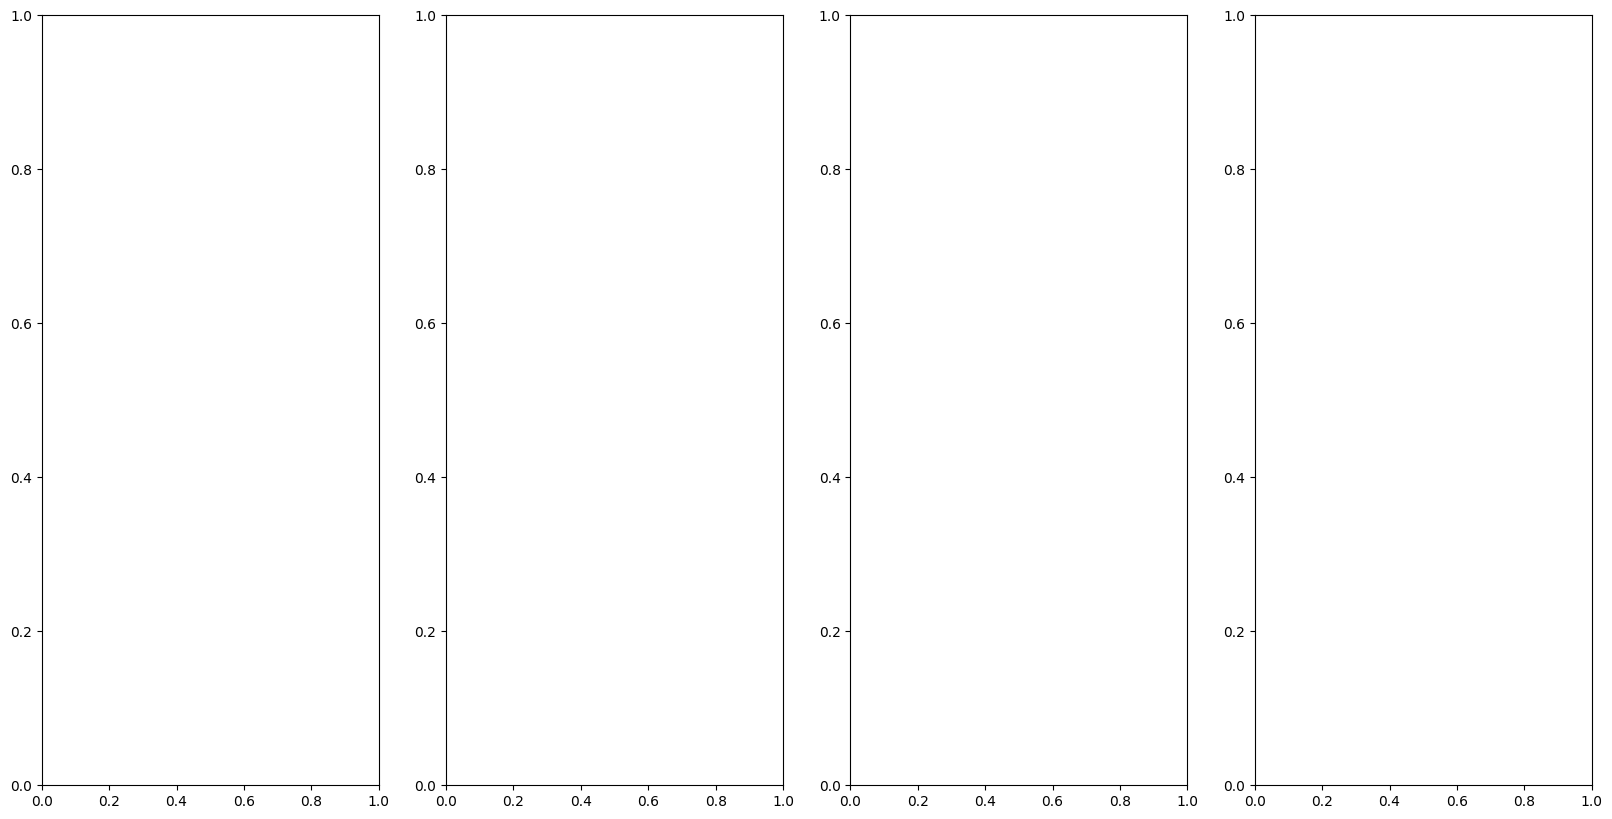

In [55]:
for layer in range(num_enc_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))
    print("Encoder Block Number", layer + 1)
    for h in range(num_heads):
        draw(
            trained_model.encoder.layers[layer]
            .MultiHeadBlock.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            inp_seq,
            inp_seq if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
plt.close()

Decoder Block number  1
Decoder Self Attention 1


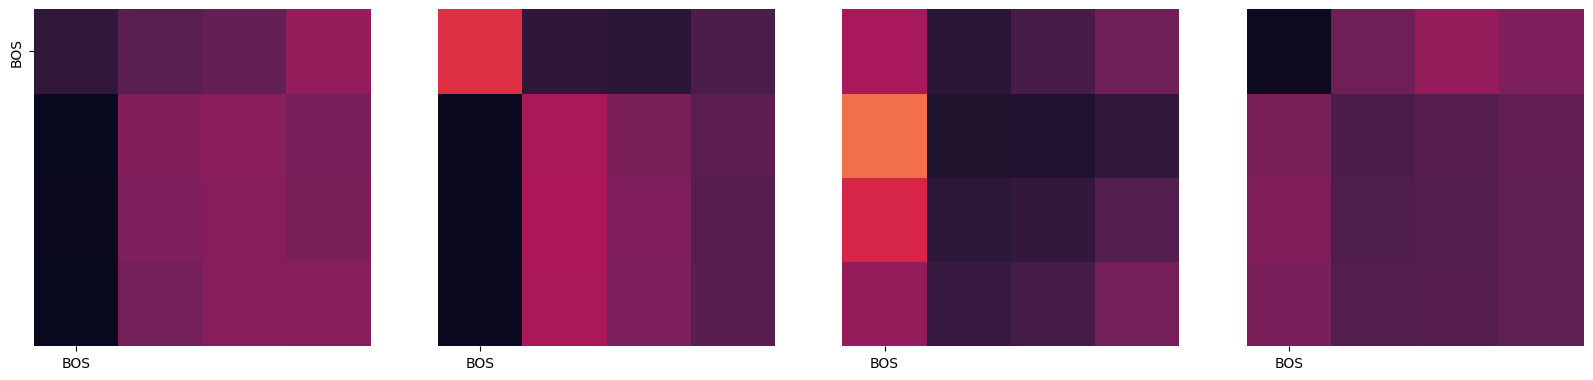

Decoder Cross attention 1


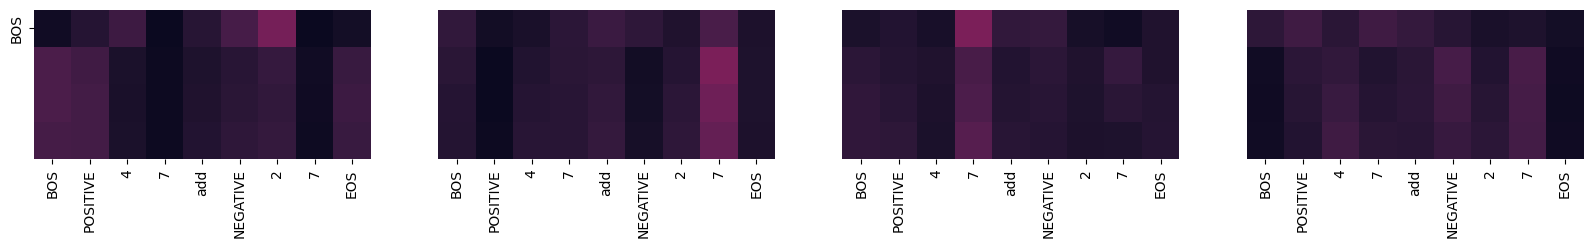

Decoder Block number  2
Decoder Self Attention 2


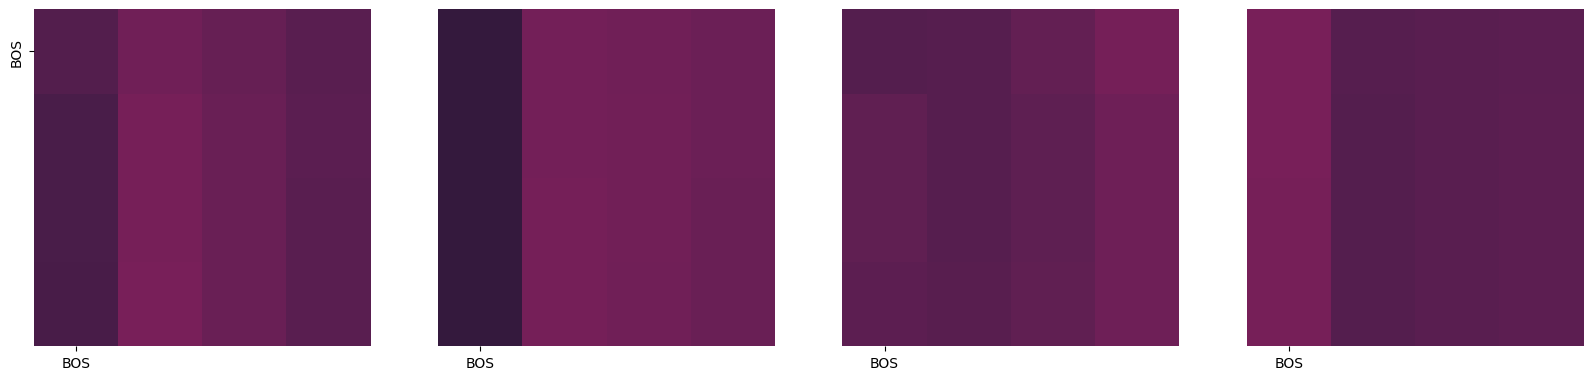

Decoder Cross attention 2


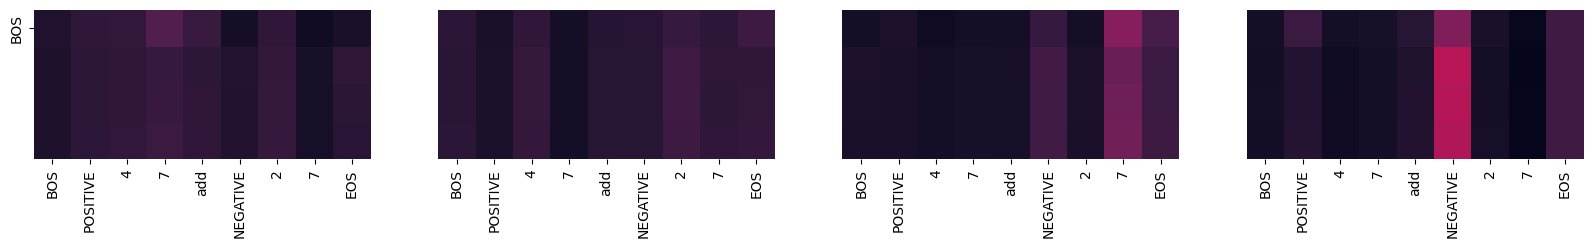

Decoder Block number  3
Decoder Self Attention 3


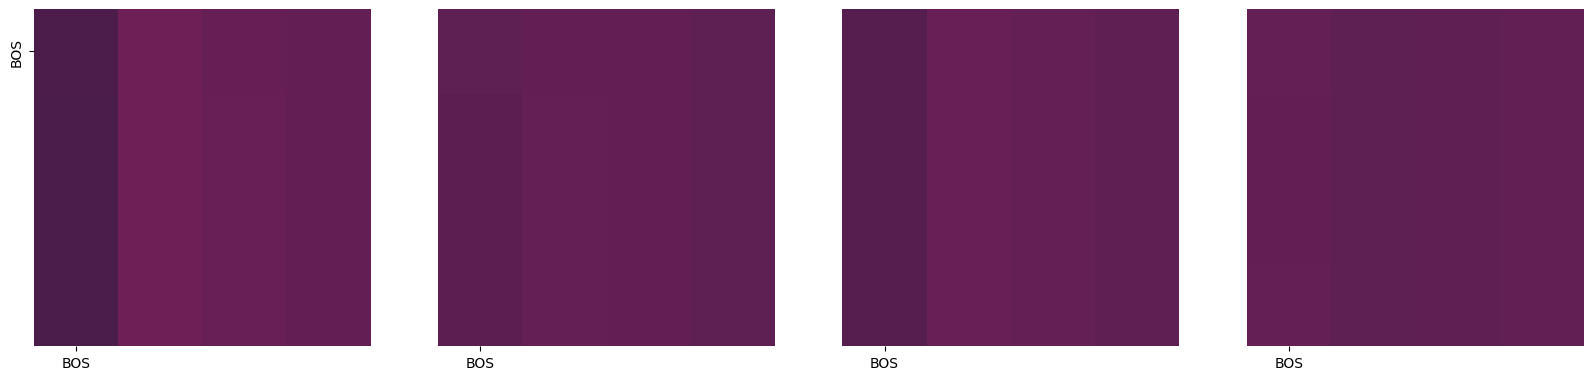

Decoder Cross attention 3


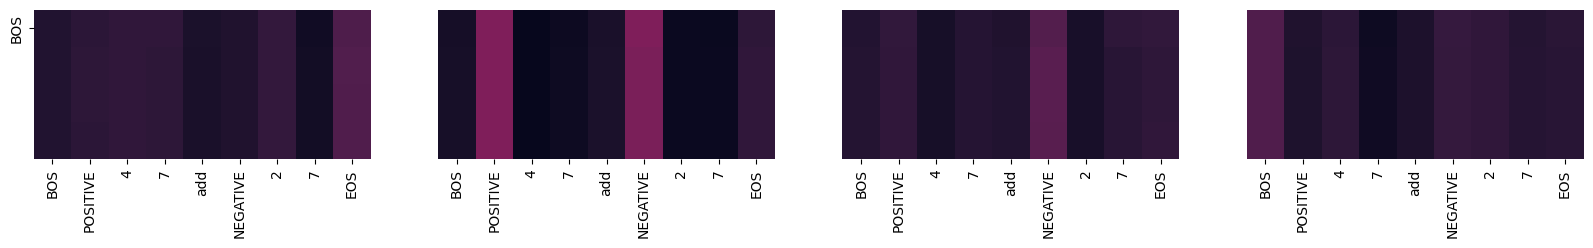

Decoder Block number  4
Decoder Self Attention 4


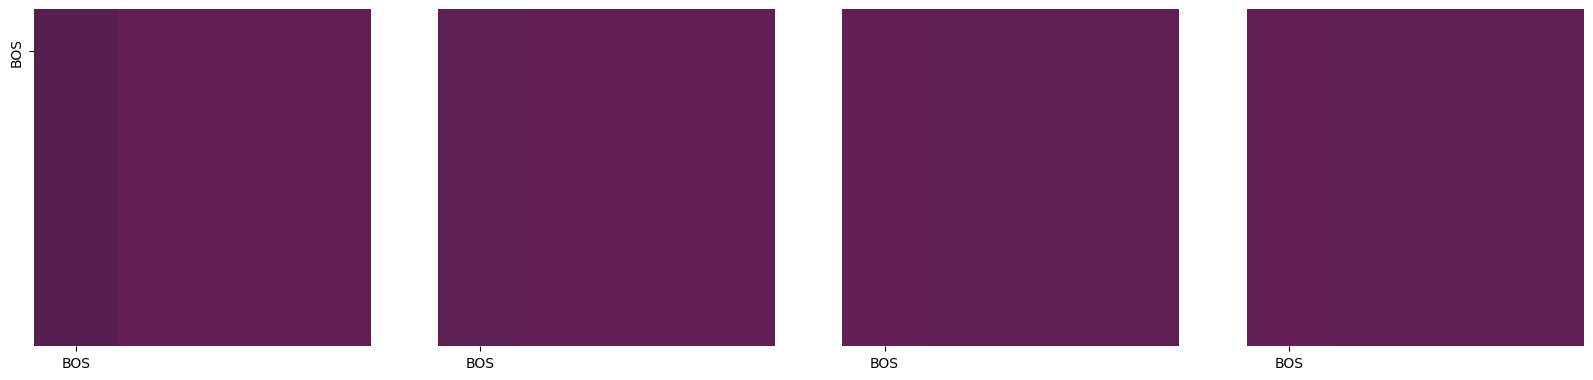

Decoder Cross attention 4


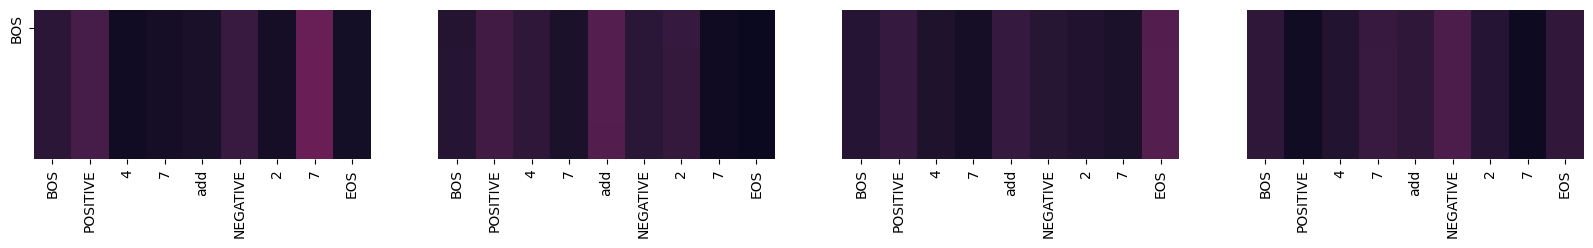

In [56]:
for layer in range(num_dec_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))

    print("Decoder Block number ", layer + 1)

    print("Decoder Self Attention", layer + 1)
    for h in range(num_heads):
        draw(
            trained_model.decoder.layers[layer]
            .attention_self.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            target_exp,
            target_exp if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
    print("Decoder Cross attention", layer + 1)
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for h in range(num_heads):
        draw(
            trained_model.decoder.layers[layer]
            .attention_cross.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            inp_seq,
            target_exp if h == 0 else [],
            ax=axs[h],
        )
    plt.show()

# Submit Your Work
After completing both notebooks for this assignment (`transformers.ipynb` and this notebook, `rnn_lstm_captionaing.ipynb`), run the following cell to create a `.zip` file for you to download and turn in.

**Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from eecs598.submit import make_a5_submission

# TODO: Replace these with your actual uniquename and umid
uniquename = None
umid = None
make_a5_submission(GOOGLE_DRIVE_PATH, uniquename, umid)